## **TIME SERIES REGRESSION ANALYSIS-CORPORATION FAVORITA**

## Business Understanding
#### **Problem Statement:**
Corporation Favorita, a leading Ecuadorian grocery retailer, aims to mitigate the risk of stockouts and excess inventory costs by developing a machine learning model to predict the likelihood of products running out of stock. Understanding the key indicators of low stock levels and implementing effective inventory management strategies are crucial for maintaining customer satisfaction and maximizing profitability.

#### **Objectives:**
1. The project task is to build a model that more accurately predicts the unit sales for thousands of items.
2. Build amd fine tune these models for a better performance
3. Identify key factors influencing sales, such as promotions, oil prices, holidays, and store characteristics.
4. Evaluate the impact of external events, such as the 2016 earthquake, on sales patterns.
5. Build a Sales Dashboard to visualize our findings with Business Intelligence tools (PowerBi/Tableau)


#### **Hypothesis:**
**Null Hypothesis (H0):**
There is no significant relationship between sales levels and products promotion.


**Alternative Hypothesis (Ha):**
There is a statistically significant relationship between sales levels and products promotion.


#### **Data for the project**
The data for this project resides in 3 places, a database, OneDrive, &
on GitHub

##### **Database**                   
Using the database credentials to access a remote server, we will 
access 3 tables in the database with the following table names.

Table 1: dbo.oil

Table 2: dbo.holidays_events

Table 3: dbo.stores

##### **OneDrive**

In this OneDrive you will find 2 more CSV files named
sample_submission.csv and test.csv. Note that these 2 two files are
going to be relevant for testing the models

##### **GitHub**
Finally, on this [GitHub Repository](https://github.com/Azubi-Africa/Career_Accelerator_LP3-Regression) , there is a zip file that contains 2 more
files you need for the project. The repository also contains very important
information about the Sprint's rubrics, and further explanations of the
features can also be found in this repository.

**Data Dictionary**
| Feature | Description | Data Type |
|-------------------|-------------|-----------| 
| store_nbr |Identifier for the store where the products are sold | Integer |
| family | Category or type of product sold | Object |
| sales | Total sales for a product family at a particular store on a given date. Fractional values are possible, indicating partial units sold (e.g., 1.5 kg of cheese) | Float |
| onpromotion | Total number of items in a product family that were being promoted at a store on a given date | Object |

#### **Business Questions:**
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

#### **Success Criteria:**
1. Model RMSLE score <= 0.2 
2. Implemented inventory management strategies should result in measurable reductions in stockouts and excess inventory costs.
3. The model should contribute to optimizing inventory levels and minimizing revenue losses due to stock shortages.
4. Customer satisfaction levels should be maintained or improved through consistent product availability.
5. The model should be adaptable to changing market conditions and scalable to accommodate larger datasets or additional features.
6. Continuous feedback loops should refine inventory management strategies based on model predictions and business performance.

#### **Future Work:**
Implement the model within Corporation Favorita's inventory management system for real-time prediction of low stock levels and proactive inventory replenishment strategies.







## Data Understanding

#### Import all Necessary Libraries

In [1]:
import os
# Data Manipulation Libraries
import pandas as pd
import numpy as np
from itertools import product

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import calplot

# Database Connectivity Libraries
import pyodbc
from dotenv import load_dotenv,dotenv_values

# Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# statistics libraries
from scipy.stats import ttest_ind

# stats model libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Data Modeling Libraries

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Utility
pd.options.display.float_format = "{:.2f}".format

# hide warnings
import warnings
warnings.filterwarnings("ignore")


#### Data Loading

In [2]:
# load environment variables
environment_variables = dotenv_values("../.env")

# connect to database
server= environment_variables.get("SERVERNAME")
username = environment_variables.get("USERNAME")
database = environment_variables.get("DATABASENAME")
password = environment_variables.get("PASSWORD")

# define connection string
connection_string = f"DRIVER={{SQL SERVER}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
#setup connection
connector = pyodbc.connect(connection_string)

print("Database Successfully Connected")

Database Successfully Connected


In [4]:
# Query Oil Table
query_1 = " SELECT * FROM dbo.oil "
oil_df = pd.read_sql(query_1,connector)
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
# Query Holidays Table
query_2 = "SELECT * FROM dbo.holidays_events"
holiday_df=pd.read_sql(query_2,connector)
holiday_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
# Query stores table
query_3 = "SELECT * FROM dbo.stores"
stores_df = pd.read_sql(query_3,connector)
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


#### Loading the training and the transaction datasets

In [7]:
# loading the train csv and convert it to pandas DataFrame
train_df = pd.read_csv("../Data/train.csv",index_col="date",parse_dates=["date"])
train_df.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.00,0
2013-01-01,1,1,BABY CARE,0.00,0
2013-01-01,2,1,BEAUTY,0.00,0
2013-01-01,3,1,BEVERAGES,0.00,0
2013-01-01,4,1,BOOKS,0.00,0


In [8]:
# Loading and Converting the transaction Data into Pandas DataFrame
transaction_df = pd.read_csv("../Data/transactions.csv",index_col="date",parse_dates=["date"])
transaction_df.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


#### Exploratory Data Analysis

In [9]:
# Load the first five rows of train_df
train_df.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.00,0
2013-01-01,1,1,BABY CARE,0.00,0
2013-01-01,2,1,BEAUTY,0.00,0
2013-01-01,3,1,BEVERAGES,0.00,0
2013-01-01,4,1,BOOKS,0.00,0


In [10]:
# Preview the last Five Rows
train_df.tail()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2017-08-15,3000883,9,POULTRY,438.13,0
2017-08-15,3000884,9,PREPARED FOODS,154.55,1
2017-08-15,3000885,9,PRODUCE,2419.73,148
2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.00,8
2017-08-15,3000887,9,SEAFOOD,16.00,0


In [11]:
# check the shape of the dataset
train_df.shape

(3000888, 5)

In [12]:
# check for duplicates
train_df.duplicated().sum()

0

In [13]:
# Drop the id column 
train_df.drop(columns="id",inplace=True)

In [14]:
# Check the info about the DataFrame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [15]:
# Check for null values
train_df.isnull().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [16]:
# Perform Descriptive Statistics On DataFrame
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,3000888.00,27.50,15.59,1.00,14.00,27.50,41.00,54.00
sales,3000888.00,357.78,1102.00,0.00,0.00,11.00,195.85,124717.00
onpromotion,3000888.00,2.60,12.22,0.00,0.00,0.00,0.00,741.00


#### Key Insights About The Data
- There are no Null and duplicated values currently present in the data
- The store numberings starts from 1 throgh to 54
- The minimum sales received daily is 0 which could be a factor of holidays or any other events.
- The maximum sales made by the store in a particular day 124717.
- The store has an average sale of 357.78 and a median sale of 11 which shows a great great variance between the sales values
- With a huge standard deviation of 1102, it can be deduced that the sales values are far apart from each other.
- About 75% of the sales made by the company in a day were less than 195.85.
- The min sales promotion is 0 and the maximum is 741.

In [17]:
# check for unique values
for col in train_df.columns:
    print(f"{col}")
    print(f"{train_df[col]}")
    print(f"There are {train_df[col].nunique()} values")
    print("="*50)

store_nbr
date
2013-01-01    1
2013-01-01    1
2013-01-01    1
2013-01-01    1
2013-01-01    1
             ..
2017-08-15    9
2017-08-15    9
2017-08-15    9
2017-08-15    9
2017-08-15    9
Name: store_nbr, Length: 3000888, dtype: int64
There are 54 values
family
date
2013-01-01                    AUTOMOTIVE
2013-01-01                     BABY CARE
2013-01-01                        BEAUTY
2013-01-01                     BEVERAGES
2013-01-01                         BOOKS
                         ...            
2017-08-15                       POULTRY
2017-08-15                PREPARED FOODS
2017-08-15                       PRODUCE
2017-08-15    SCHOOL AND OFFICE SUPPLIES
2017-08-15                       SEAFOOD
Name: family, Length: 3000888, dtype: object
There are 33 values
sales
date
2013-01-01      0.00
2013-01-01      0.00
2013-01-01      0.00
2013-01-01      0.00
2013-01-01      0.00
               ...  
2017-08-15    438.13
2017-08-15    154.55
2017-08-15   2419.73
2017-08-15    

#### Check for unique values in the data

In [18]:
# look further into the unique values in the family column
train_df["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

#### Check for Completeness of Data

In [19]:
start_date = train_df.index.min()
end_date = train_df.index.max()

print(f"Start date is {start_date}")
print(f"End date is {end_date}")

Start date is 2013-01-01 00:00:00
End date is 2017-08-15 00:00:00


In [20]:
# check for date range
date_range = pd.date_range(start=start_date,end=end_date,freq="D")
date_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [21]:
# check for missing date
existing_dates = train_df.index
missing_dates = date_range.difference(existing_dates)
missing_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

#### Filling missing dates With the Family Column

In [22]:
# check for unique values in the family column
families = train_df["family"].unique()

print(f"The unique product family in the table are {families.size}")
families

The unique product family in the table are 33


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [23]:
# check for unique stores in the store_nbr column
stores = train_df["store_nbr"].unique()

print(f"The unique number of stores in the table are {stores.size}")
stores

The unique number of stores in the table are 54


array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

#### Create new data for missing dates

In [24]:
# Create New Data points for the missing dates
missing_data = product(missing_dates,stores,families)

# Create a DataFrame for the missing data
missing_df = pd.DataFrame(data=missing_data,columns=["date","store_nbr","family"])
missing_df.set_index("date",inplace=True)
missing_df

,store_nbr,family
date,,
2013-12-25,1,AUTOMOTIVE
2013-12-25,1,BABY CARE
2013-12-25,1,BEAUTY
2013-12-25,1,BEVERAGES
2013-12-25,1,BOOKS
...,...,...
2016-12-25,9,POULTRY
2016-12-25,9,PREPARED FOODS
2016-12-25,9,PRODUCE


In [25]:
# check for the shape of the missing data
missing_df.shape

(7128, 2)

In [26]:
# Concatenate train_df to missing_df
final_train_df = pd.concat([train_df,missing_df],axis=0)
final_train_df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00
2013-01-01,1,BABY CARE,0.00,0.00
2013-01-01,1,BEAUTY,0.00,0.00
2013-01-01,1,BEVERAGES,0.00,0.00
2013-01-01,1,BOOKS,0.00,0.00
...,...,...,...,...
2016-12-25,9,POULTRY,NaN,NaN
2016-12-25,9,PREPARED FOODS,NaN,NaN
2016-12-25,9,PRODUCE,NaN,NaN


In [27]:
# Check for Nulls
final_train_df.isna().sum()

store_nbr         0
family            0
sales          7128
onpromotion    7128
dtype: int64

#### Filling Null Values in the final_train_df

In [28]:
final_train_df["sales"].fillna(0,inplace=True)
final_train_df["onpromotion"].fillna(0,inplace=True)

In [29]:
# Confirm changes after filling the Null Values
final_train_df.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [30]:
# check the shape of the final_train_df
final_train_df.shape

(3008016, 4)

In [31]:
# confirm the filling of missing dates
existing_dates = final_train_df.index
missing_dates = date_range.difference(existing_dates)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

#### Univariate Analysis

#### Box Plots 

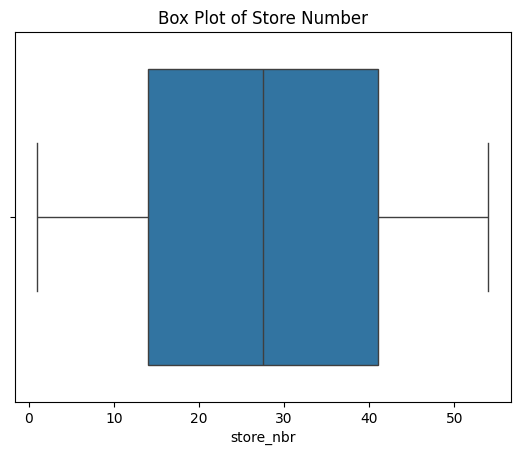

In [32]:
# check for outliers in the dataset
sns.boxplot(final_train_df["store_nbr"],orient="h")
plt.title("Box Plot of Store Number")
plt.show()

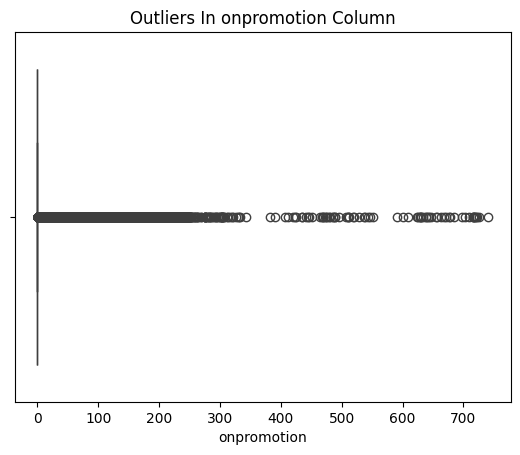

In [33]:
# check for outliers in the dataset
sns.boxplot(final_train_df["onpromotion"],orient="h")
plt.title("Outliers In onpromotion Column")
plt.show()

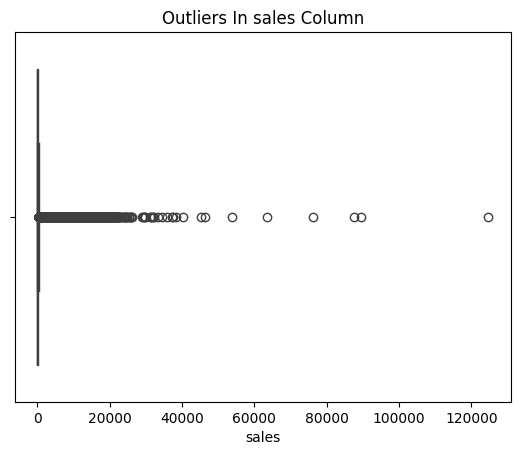

In [34]:
# check for outliers in the dataset
sns.boxplot(final_train_df["sales"],orient="h")
plt.title("Outliers In sales Column")
plt.show()

#### Density Plots

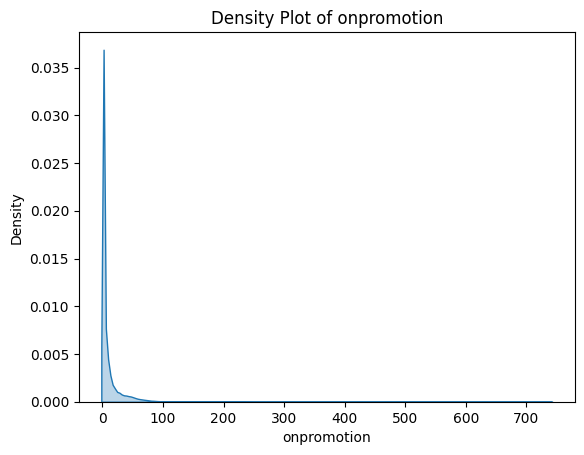

In [35]:
# KDE plot to visualize skewness of data
sns.kdeplot(final_train_df["onpromotion"],alpha=0.3,fill=True)
plt.title("Density Plot of onpromotion")
plt.show()

In [36]:
# check for skewness of data
numerical_columns = final_train_df.select_dtypes(include=["number"]).columns
skewness = train_df[numerical_columns].skew()
skewness

store_nbr      0.00
sales          7.36
onpromotion   11.17
dtype: float64

#### Bivariate Analysis

#### Line Plots

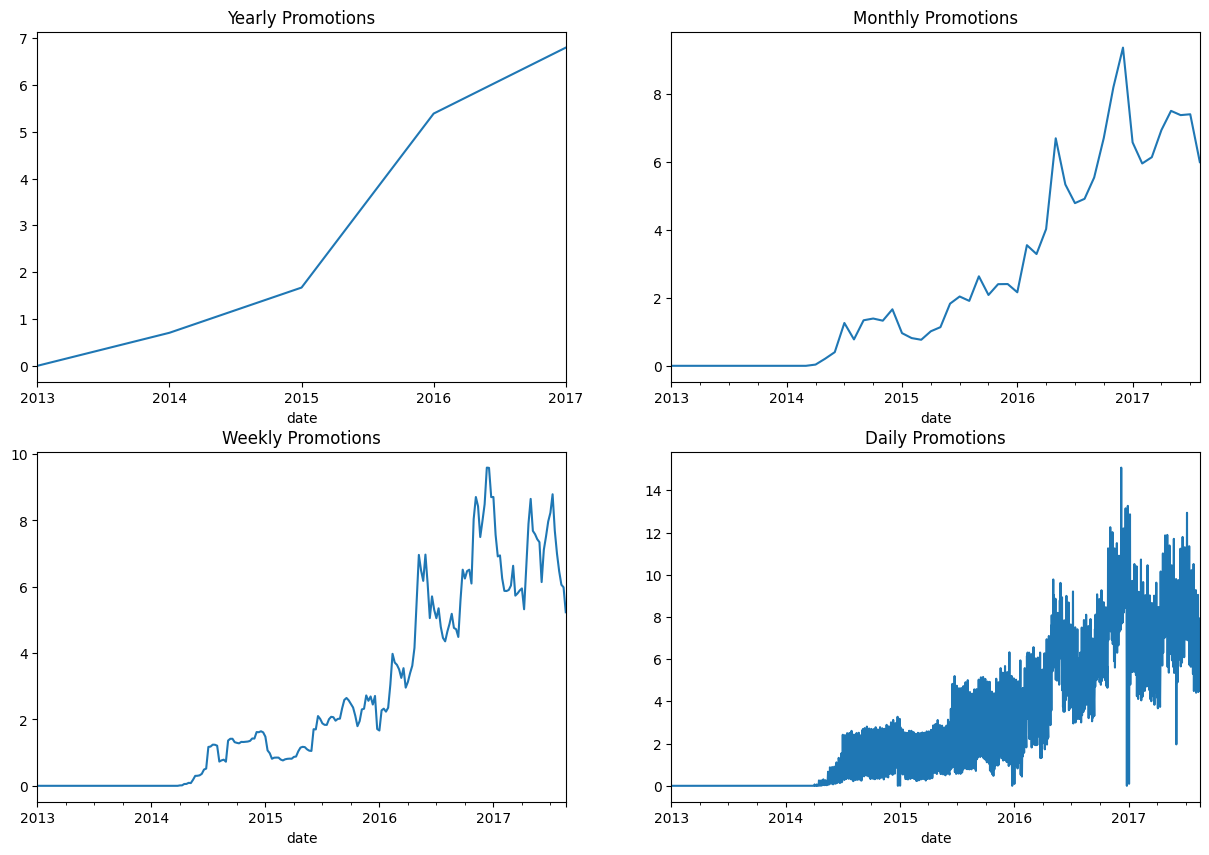

In [37]:
# Plotting the "onpromotion" column
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
# Resample on promotion by month
yearly_promo = final_train_df["onpromotion"].resample("Y").mean()
# Using matplotlib to visualize
yearly_promo.plot()
# Adding a title to the plot
plt.title('Yearly Promotions')

plt.subplot(2,2,2)
# Resample on promotion by month
monthly_promo = final_train_df["onpromotion"].resample("M").mean()
# Using matplotlib to visualize
monthly_promo.plot()
# Adding a title to the plot
plt.title('Monthly Promotions')

plt.subplot(2,2,3)
# Resample on promotion by month
weekly_promo = final_train_df["onpromotion"].resample("W").mean()
# Using matplotlib to visualize
weekly_promo.plot()
# Adding a title to the plot
plt.title('Weekly Promotions')

plt.subplot(2,2,4)
# Resample on promotion by day
daily_promo = final_train_df["onpromotion"].resample("D").mean()
# Using matplotlib to visualize  
daily_promo.plot()
# Adding a title to the plot
plt.title('Daily Promotions')


plt.show()

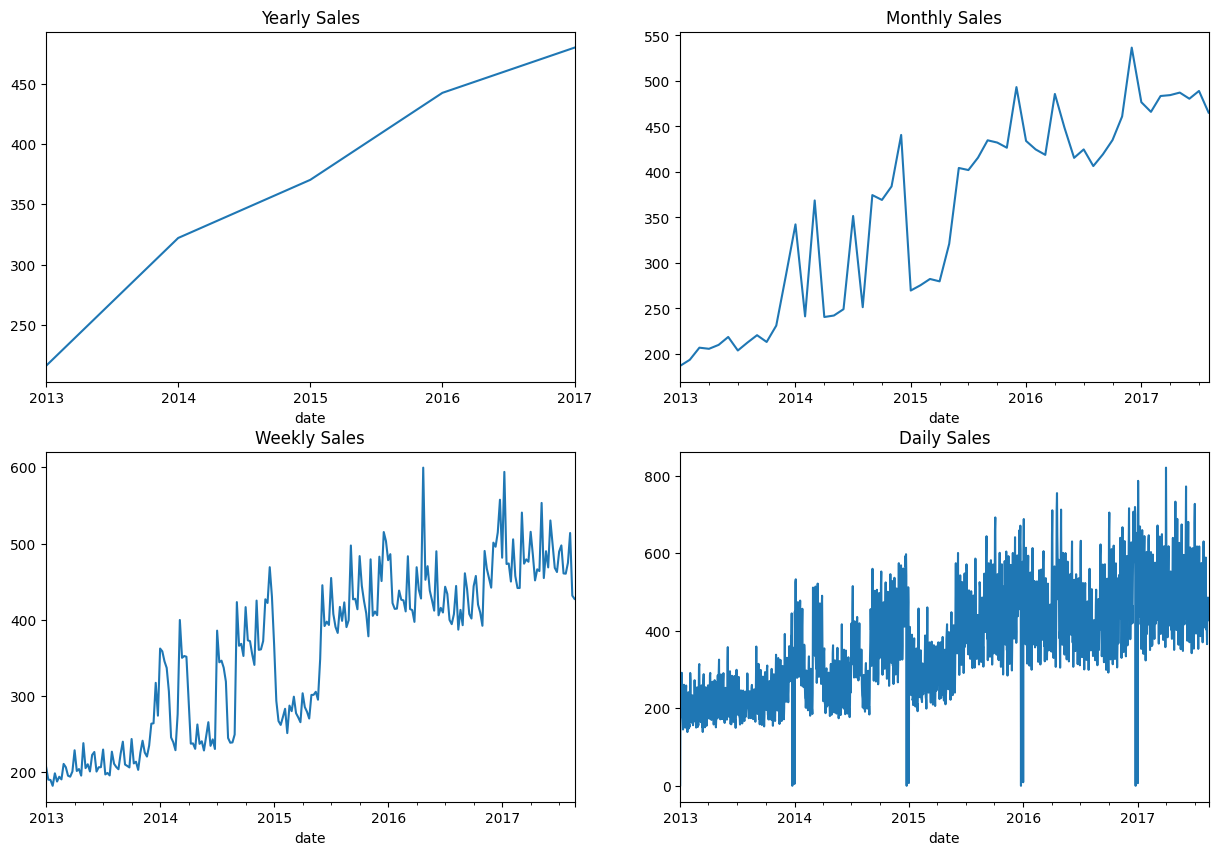

In [38]:
# Plotting the "onpromotion" column
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
# Resample on promotion by month
yearly_promo = final_train_df["sales"].resample("Y").mean()
# Using matplotlib to visualize
yearly_promo.plot()
# Adding a title to the plot
plt.title('Yearly Sales')

plt.subplot(2,2,2)
# Resample on promotion by month
monthly_promo = final_train_df["sales"].resample("M").mean()
# Using matplotlib to visualize
monthly_promo.plot()
# Adding a title to the plot
plt.title('Monthly Sales')

plt.subplot(2,2,3)
# Resample on promotion by month
weekly_promo = final_train_df["sales"].resample("W").mean()
# Using matplotlib to visualize
weekly_promo.plot()
# Adding a title to the plot
plt.title('Weekly Sales')

plt.subplot(2,2,4)
# Resample on promotion by day
daily_promo = final_train_df["sales"].resample("D").mean()
# Using matplotlib to visualize  
daily_promo.plot()
# Adding a title to the plot
plt.title('Daily Sales')


plt.show()

#### Multivariate Analysis

#### Create New Features from the Date Index

In [39]:
# Create new features
def create_features(final_train_df):
    final_train_df["month_name"] = final_train_df.index.month_name()
    final_train_df["month"] = final_train_df.index.month
    final_train_df["year"] = final_train_df.index.year
    final_train_df["day"] = final_train_df.index.dayofweek
    final_train_df["day_name"] = final_train_df.index.day_name()
    final_train_df["day_of_month"] = final_train_df.index.day
    final_train_df["quarter"] = final_train_df.index.quarter
    return final_train_df

final_train_df = create_features(final_train_df)
final_train_df


,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter
date,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,1,1
2013-01-01,1,BABY CARE,0.00,0.00,January,1,2013,1,Tuesday,1,1
2013-01-01,1,BEAUTY,0.00,0.00,January,1,2013,1,Tuesday,1,1
2013-01-01,1,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,1,1
2013-01-01,1,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-25,9,POULTRY,0.00,0.00,December,12,2016,6,Sunday,25,4
2016-12-25,9,PREPARED FOODS,0.00,0.00,December,12,2016,6,Sunday,25,4
2016-12-25,9,PRODUCE,0.00,0.00,December,12,2016,6,Sunday,25,4


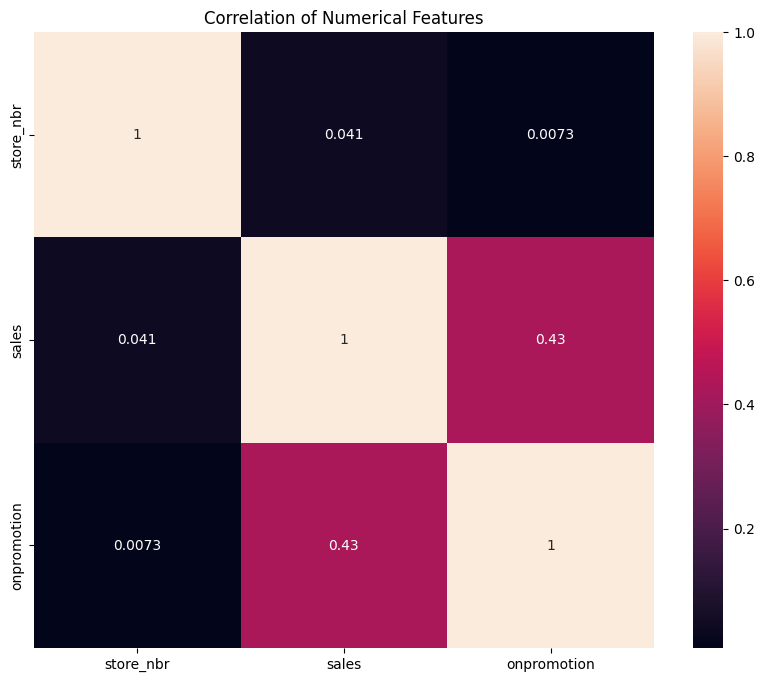

In [40]:
# Correlation without date
# Plot Heatmap To Visualize The Correlation of Features
correlation_without_date = final_train_df.drop(columns=["family","month_name","day_name","day_of_month","month","year","day","quarter"]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_without_date,annot=True,)
plt.title("Correlation of Numerical Features")
plt.show()

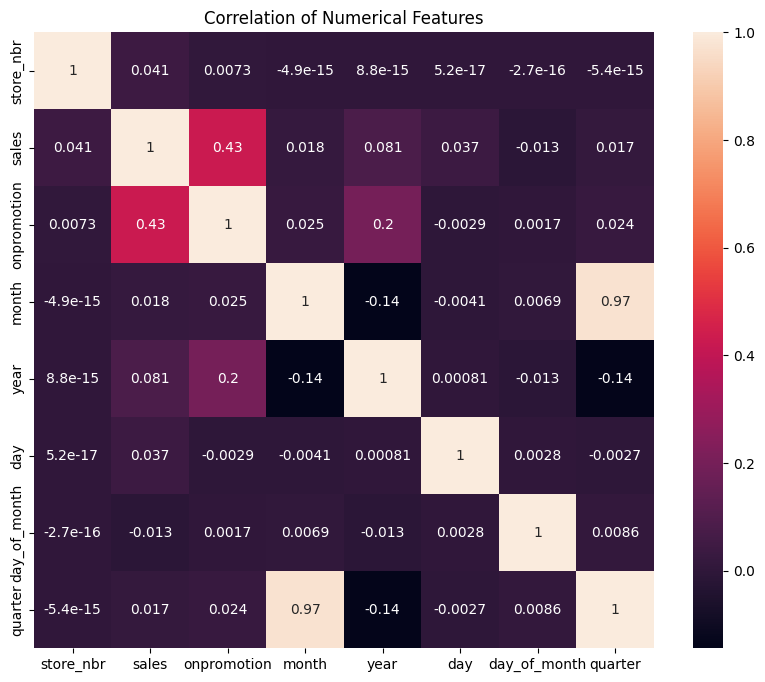

In [41]:
# Plot Heatmap To Visualize The Correlation of Features
correlation_matrix_with_date = final_train_df.drop(columns=["family","day_name","month_name"]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_with_date,annot=True,)
plt.title("Correlation of Numerical Features")
plt.show()

#### Visualize Sales Distribution on calenderplot

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


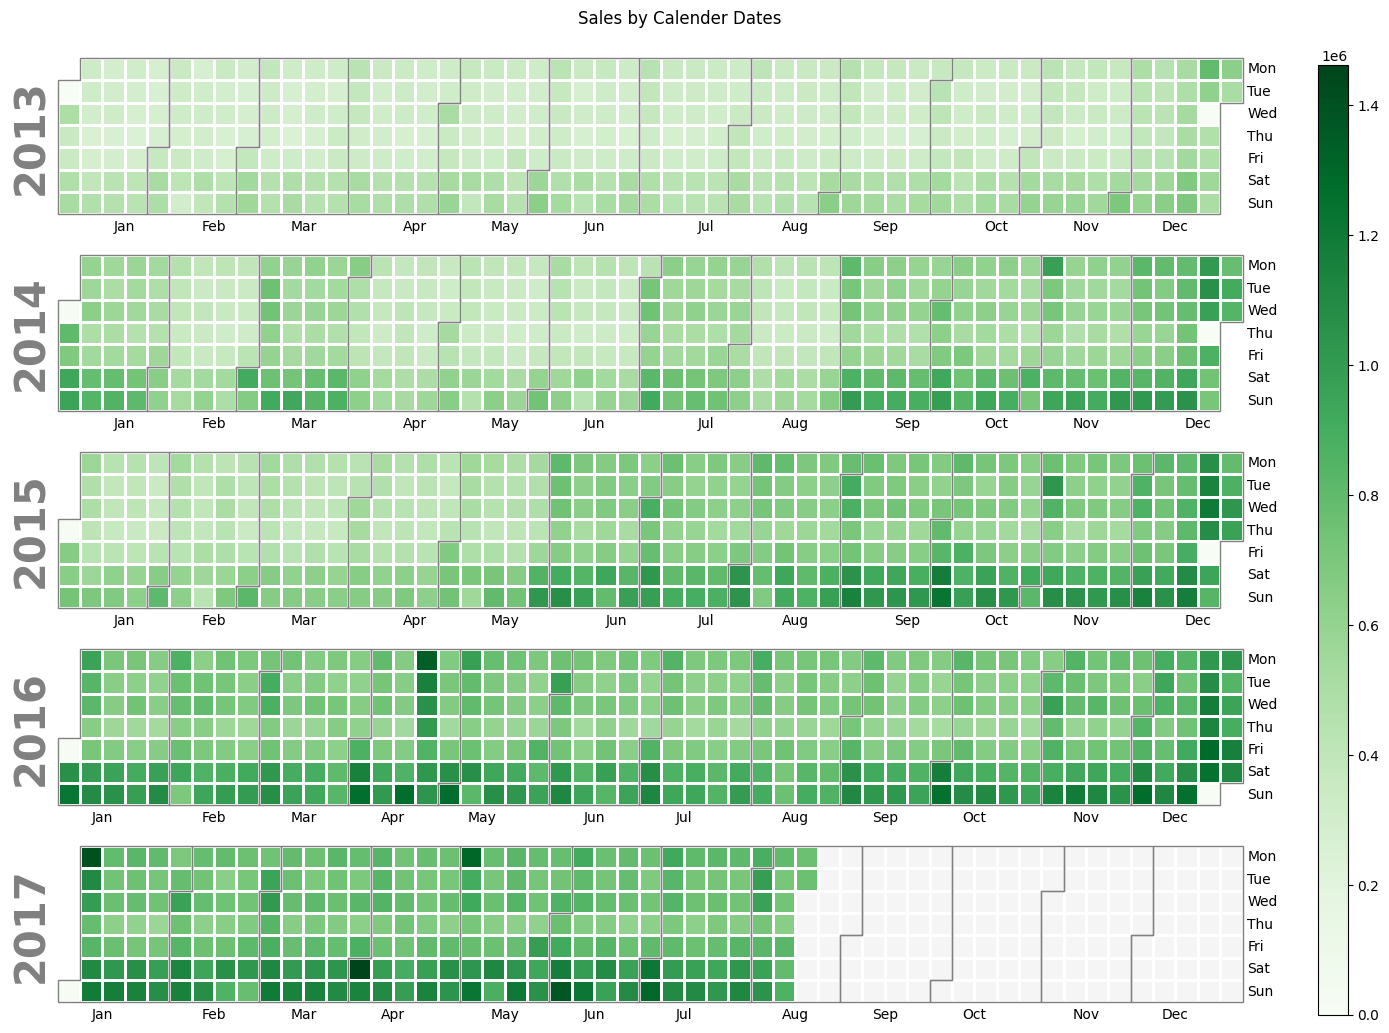

In [42]:
# visualize sales distribution on calenderplot
calplot.calplot(final_train_df["sales"],how=sum, cmap="Greens",figsize=(15,10),suptitle="Sales by Calender Dates")
plt.show()

#### Decomposition

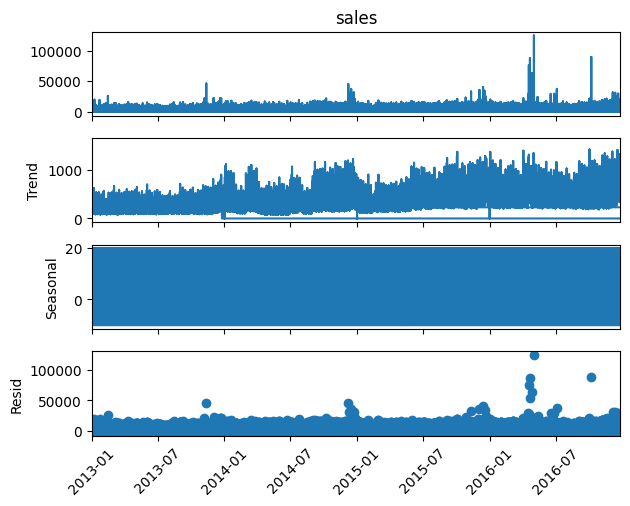

In [43]:
additive_results = seasonal_decompose(final_train_df["sales"],model="additive",period=365)
additive_results.plot()
plt.rcParams.update({'figure.figsize':(15,10)})
plt.xticks(rotation=45)
plt.show()

In [44]:
# Extract Components of Decomposition
decomposition_df = pd.DataFrame({
    "trend":additive_results.trend,
    "seasonal":additive_results.seasonal,
    "residual":additive_results.resid,
    "observed":additive_results.observed
})

decomposition_df.tail()

,trend,seasonal,residual,observed
date,,,,
2016-12-25,NaN,0.56,NaN,0.00
2016-12-25,NaN,-3.57,NaN,0.00
2016-12-25,NaN,-0.32,NaN,0.00
2016-12-25,NaN,3.10,NaN,0.00
2016-12-25,NaN,-2.02,NaN,0.00


#### Check For Stationarity

In [45]:
# Resample and calculate the mean only on the sales column
df_downsampled = final_train_df[["sales"]].resample("W").mean()

# check if there are Null values and handle them
df_downsampled.fillna(0,inplace=True)
df_downsampled

,sales
date,
2013-01-06,206.84
2013-01-13,190.29
2013-01-20,189.84
2013-01-27,182.15
2013-02-03,198.56
...,...
2017-07-23,460.50
2017-07-30,474.73
2017-08-06,513.88


In [46]:
# Use Adfuller to check for stationarity
adftest = adfuller(df_downsampled["sales"])
print(f"ADF statistics: {adftest[0]}")
print(f"p-value: {adftest[1]}")
print(f"Critical values: {adftest[4]}")

if adftest[1] > 0.05:
    print("The series is non-stationary")
else:
    print("The series is stationary")


ADF statistics: -1.481750917756026
p-value: 0.5425188110982643
Critical values: {'1%': -3.4593607492757554, '5%': -2.8743015807562924, '10%': -2.5735714042782396}
The series is non-stationary


From the ADFuller test with a p_value of 0.5425, we can confidently say that the series is not stationary 

#### Visualizing Stationarity Using Rolling Statistics

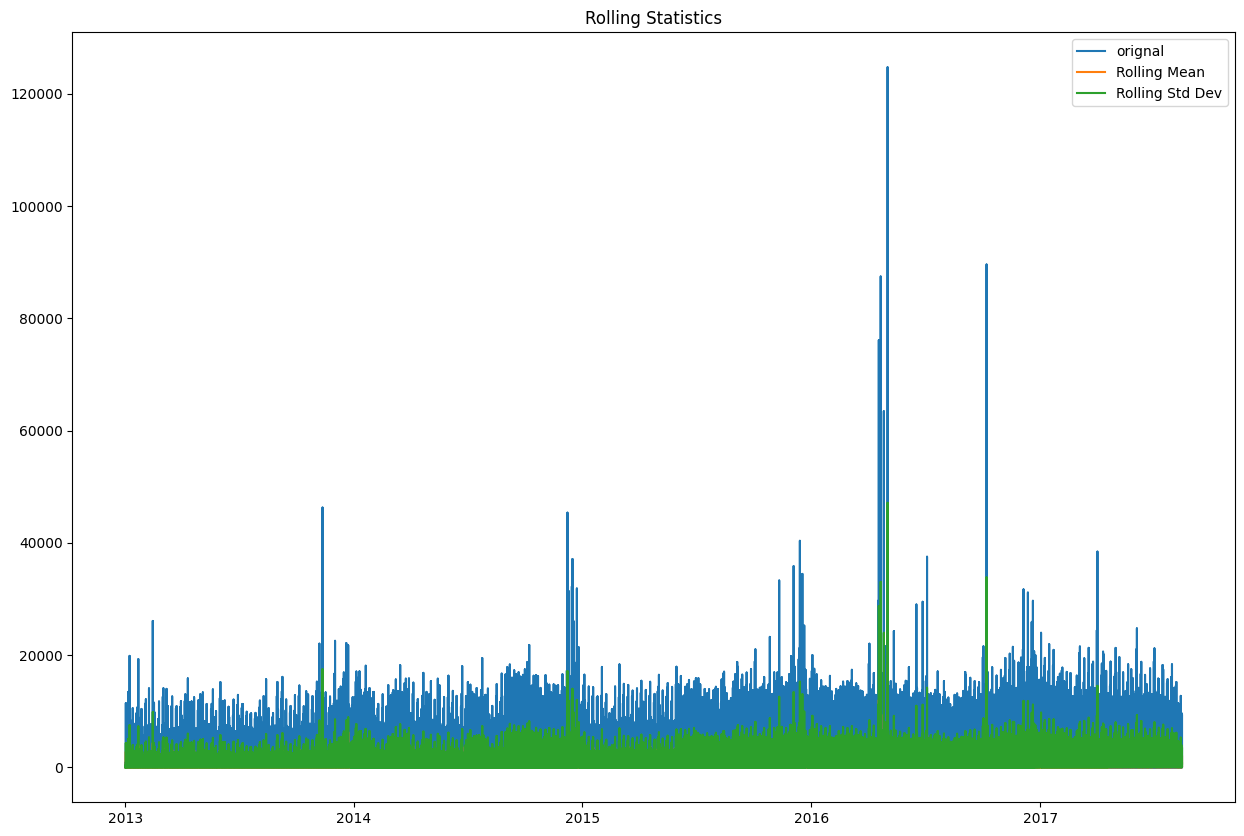

In [47]:
# Rolling Mean and Standard Deviation
rolling_mean = final_train_df["sales"].rolling(window=7).mean()
rolling_std = final_train_df["sales"].rolling(window=7).std()

# Plot Rolling Statistics
plt.plot(final_train_df["sales"],label="orignal")
plt.plot(rolling_mean,label="Rolling Mean")
plt.plot(rolling_std,label="Rolling Std Dev")
plt.legend(loc="best")
plt.title("Rolling Statistics")
plt.show()

#### Plot of Partial Autocorrelation Function (PACF) and Autocorrelation Function (ACF)

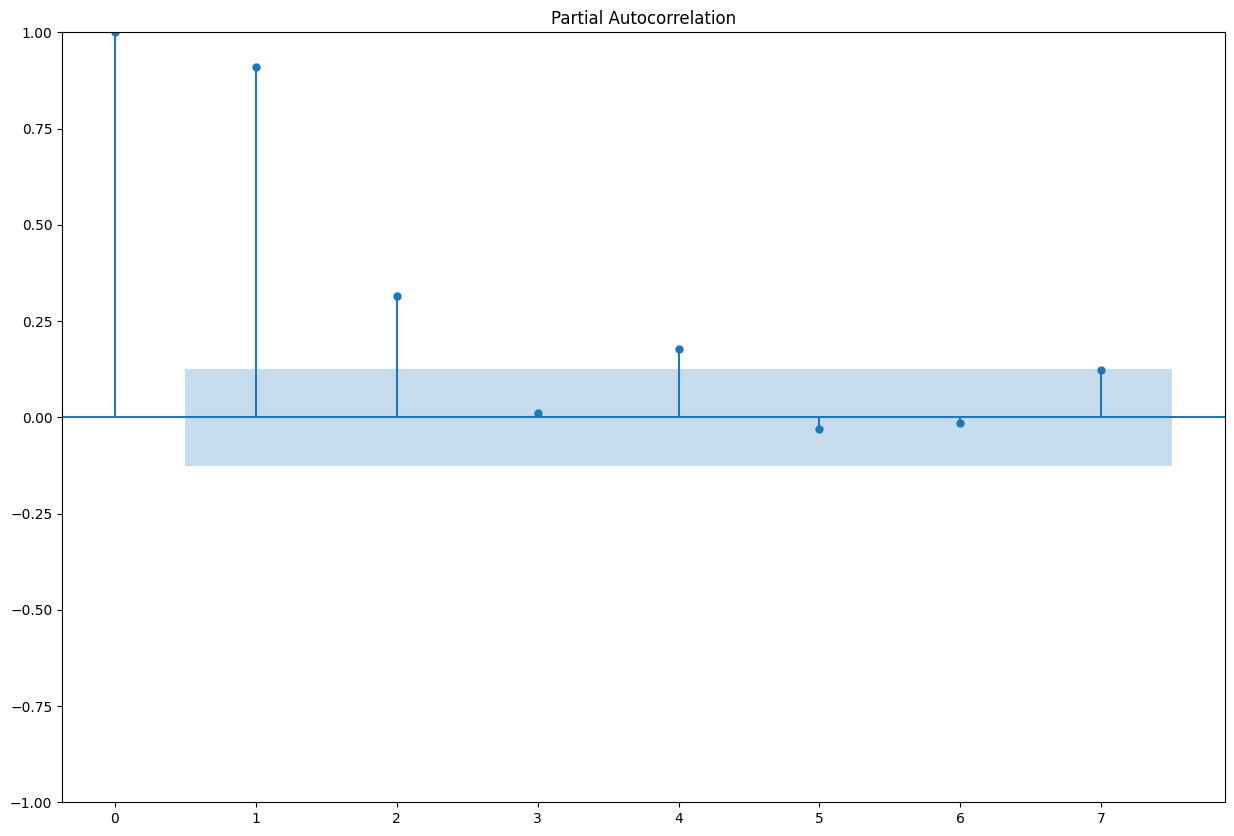

In [48]:
#Plot Partial-Autocorrelation function
plot_pacf(df_downsampled["sales"],lags=7)
plt.show()

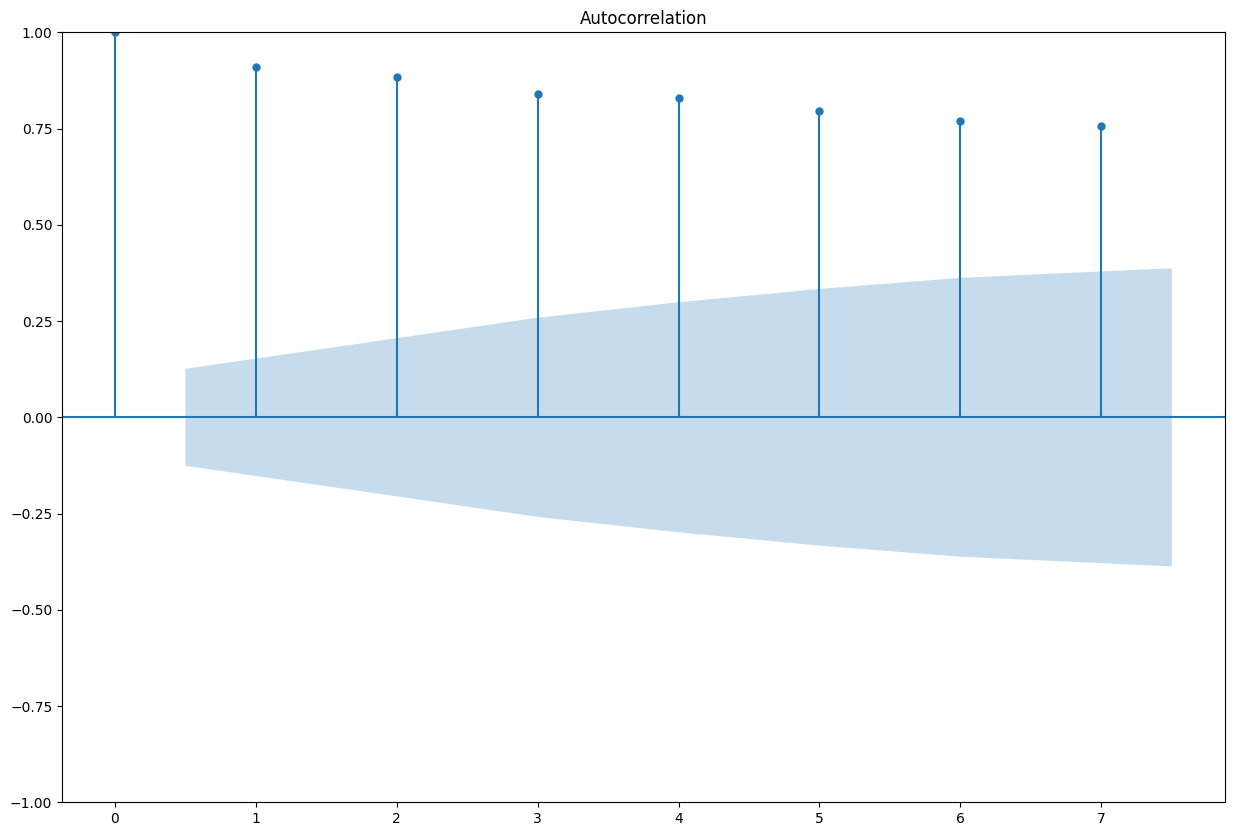

In [49]:
#Plot Autocorrelation function
plot_acf(df_downsampled["sales"],lags=7)
plt.show()

#### Key Insights 
- From the box plots above, we can see that the sales and the onpromotion columns contains a lot of outliers which must be looked at.
- We can see that the dataset isn't normally distributed.
- The sales and the onpromotion features are positively skewed to the right.
- From the heatmap, we can see that promotion has the highest correlation with the sales column
-  We can see from the line plots and the seasonal decomposition graph that there is a positive trend in both sales and sales promotion for the years.
- There is no seasonality in the sales for the years from the decomposition.


#### Answering Business Questions

#### Question 1
Is the train dataset complete (has all the required dates)?


In [50]:
print(f"The missing dates in the dataset are:\n{missing_dates}")

The missing dates in the dataset are:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


#### Question 2
Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

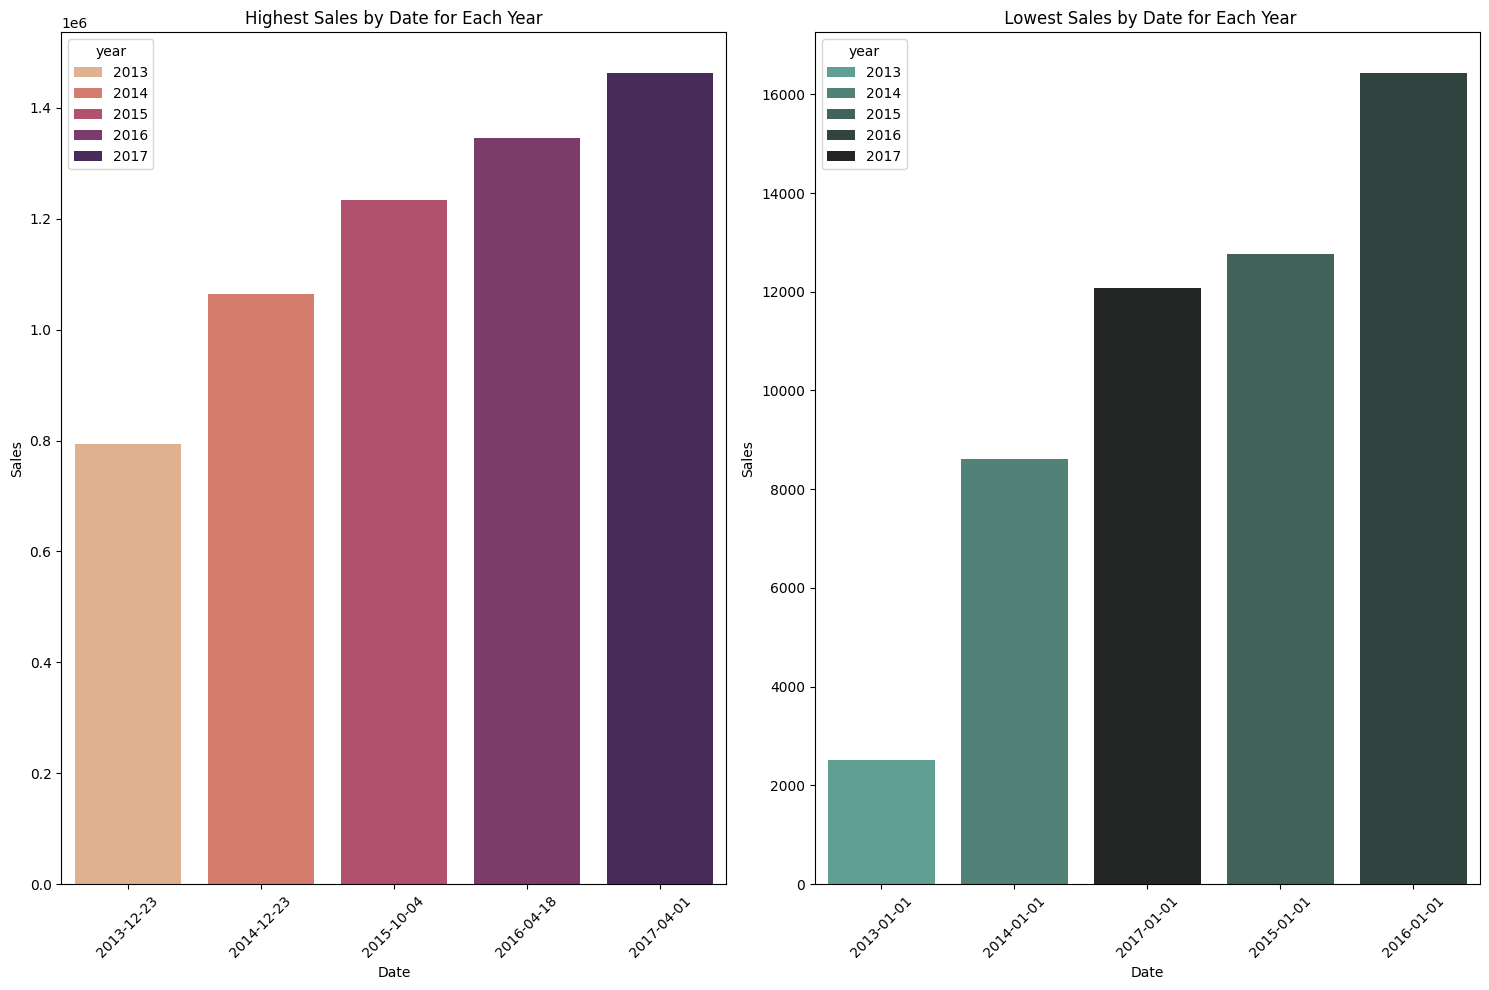

In [51]:
# filter days where the store wasn't opened
sum_of_sales = final_train_df.groupby(final_train_df.index)["sales"].sum()
active_days = final_train_df[sum_of_sales != 0 ]

# Find the highest and the lowest sales per yer from the active_days
sales_dist = active_days.groupby(by=[active_days.index.year,active_days.index])["sales"].sum().sort_values(ascending=True)

# Find the dates with the highest and lowest sales for each year
highest_sales = sales_dist.groupby(level=0).tail(1).reset_index(level=0)
lowest_sales = sales_dist.groupby(level=0).head(1).reset_index(level=0)

# Rename the index column
highest_sales.rename(columns={highest_sales.index.name: "year", "sales": "Sales_Highest"}, inplace=True)
lowest_sales.rename(columns={lowest_sales.index.name: "year", "sales": "Sales_Lowest"}, inplace=True)

# # Plotting
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.barplot(data=highest_sales,x=highest_sales.index, y=highest_sales["Sales_Highest"],hue="year",palette="flare")
plt.title("Highest Sales by Date for Each Year")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1,2,2)
sns.barplot(data=lowest_sales,x=lowest_sales.index, y=lowest_sales["Sales_Lowest"],hue="year",palette="dark:#5A9_r")
plt.title(" Lowest Sales by Date for Each Year")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Question 3
Compare the sales for each month across the years and determine which month of which year had the highest sales.

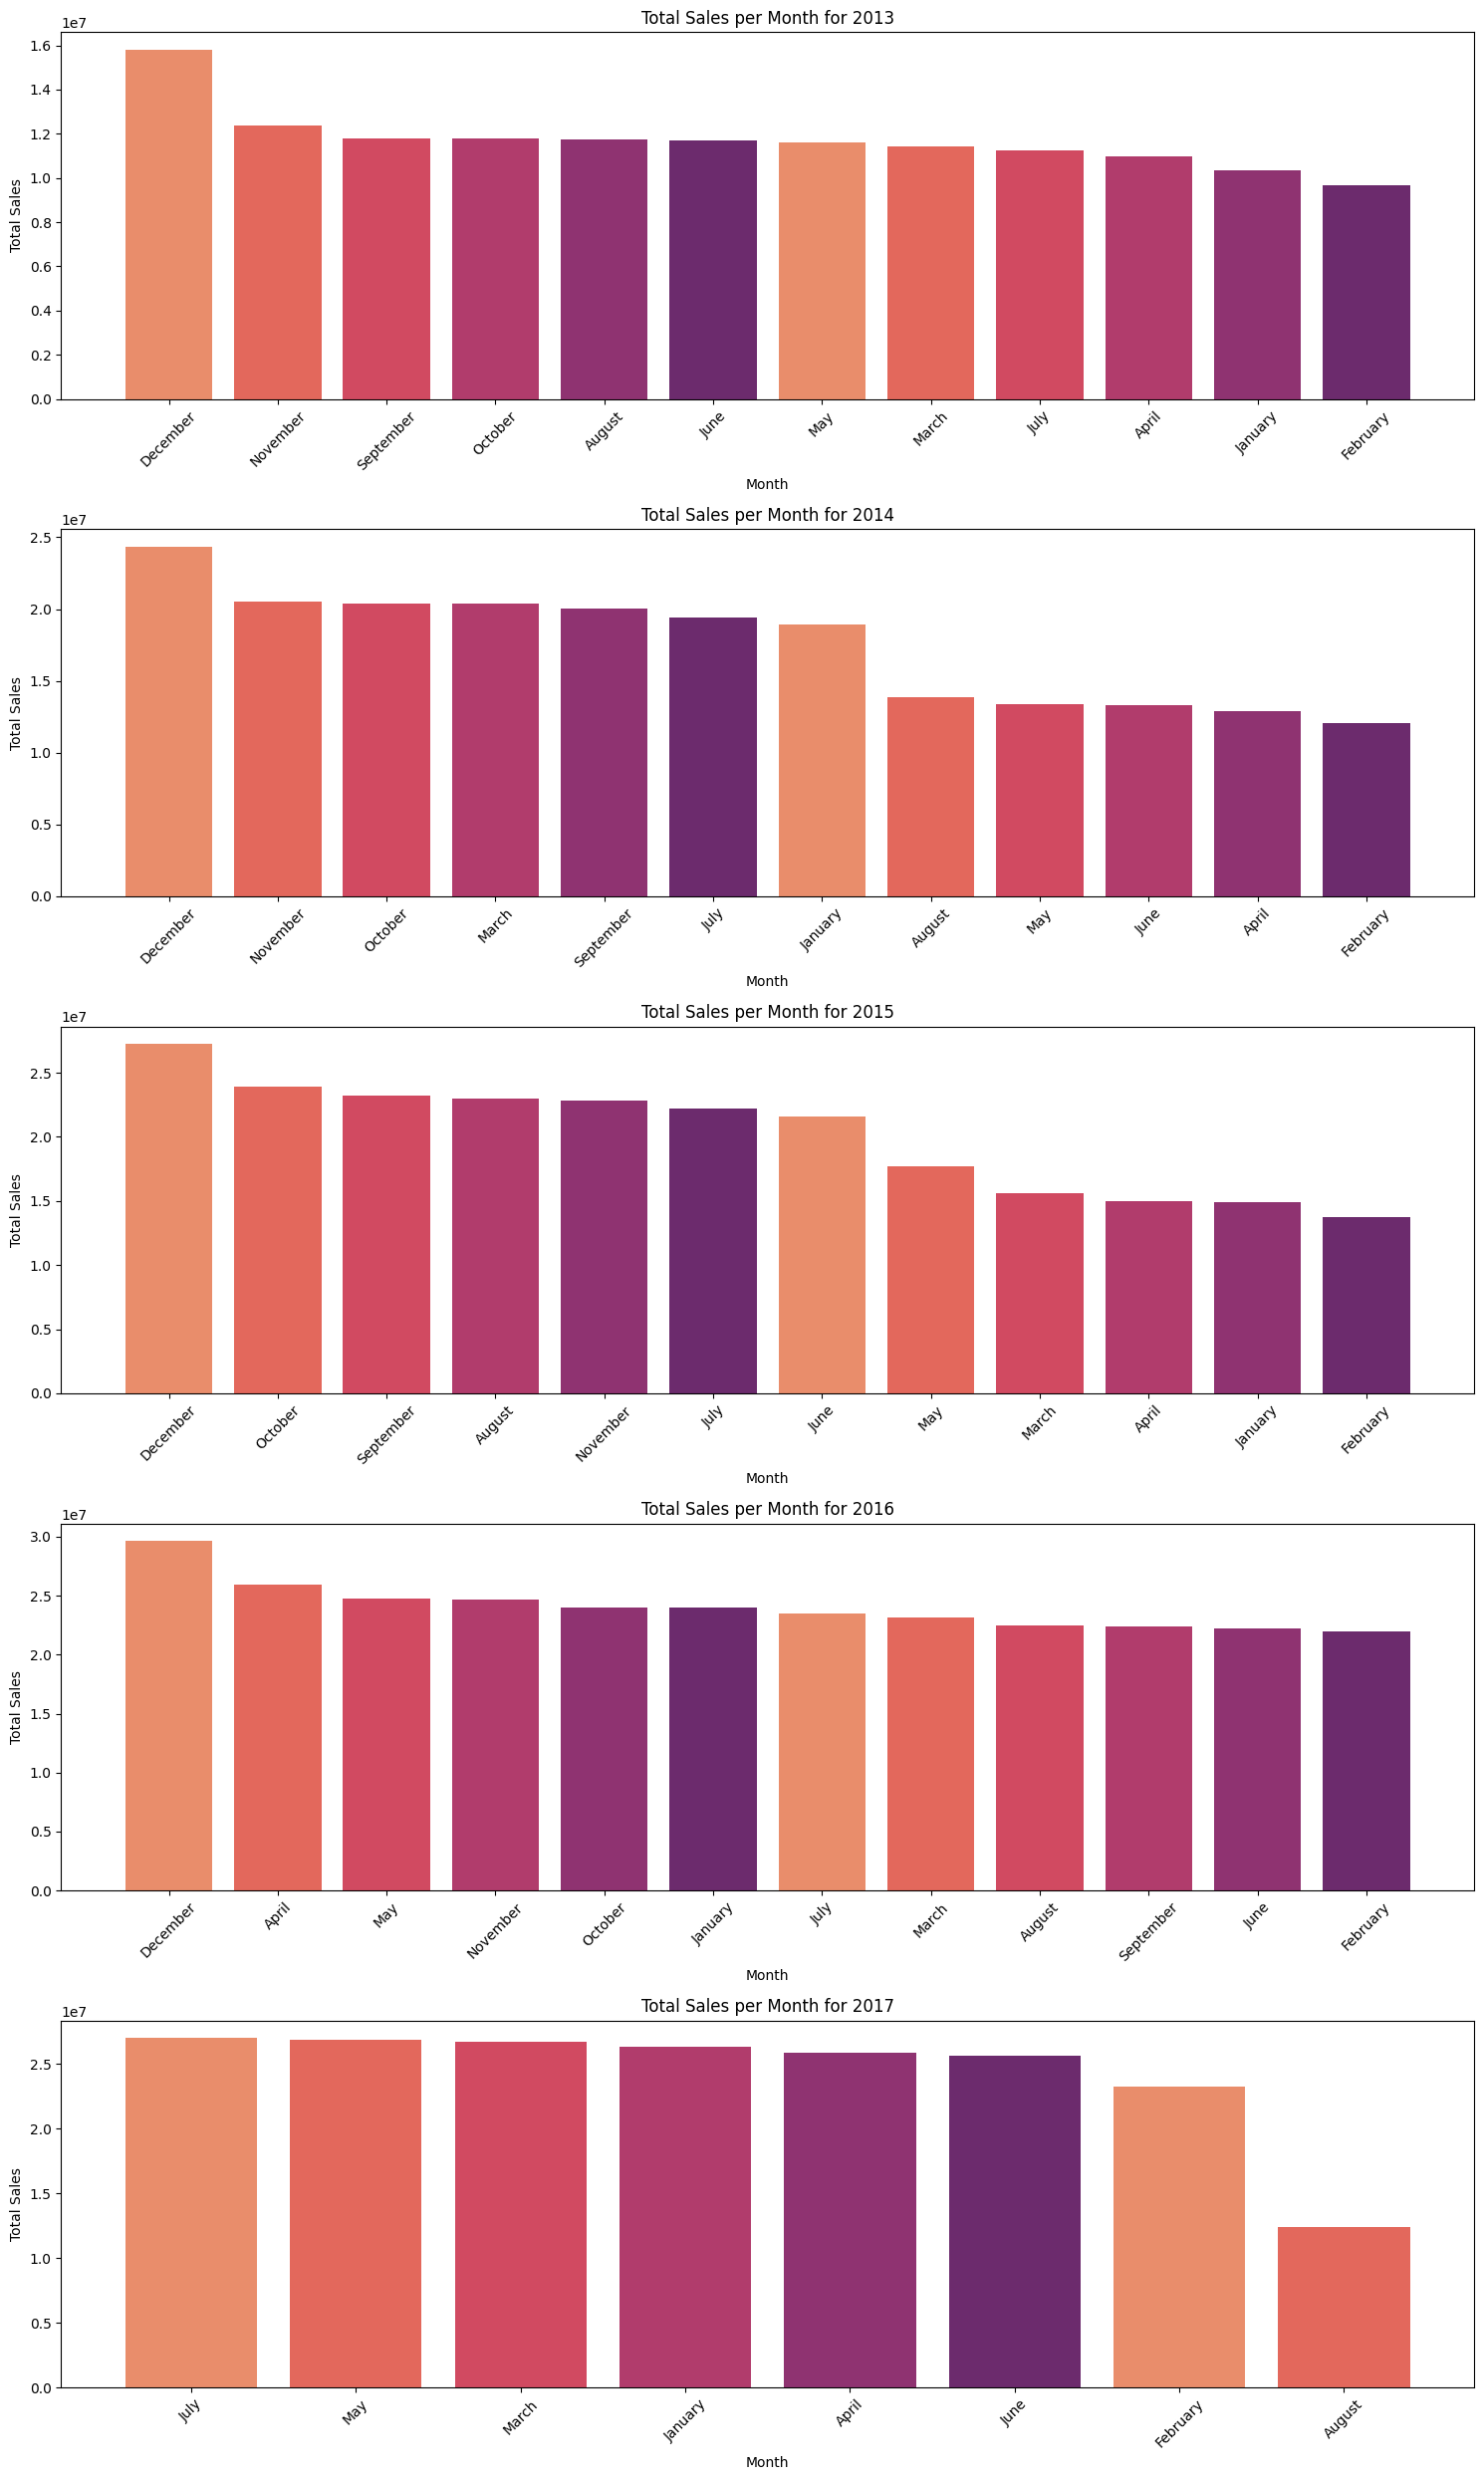

In [52]:
unique_years = final_train_df["year"].unique()
month = final_train_df["month_name"]
custom_palette = sns.color_palette("flare")
# Plotting
fig,axs = plt.subplots(nrows = len(unique_years),ncols=1,figsize=(15,5*len(unique_years)))

# iterate over unique years
for i, yr in enumerate(unique_years):
    # Filter data for the current year
    sales_data_year = final_train_df[final_train_df["year"] == yr] 
    grouped_sales = sales_data_year.groupby("month_name")["sales"].sum().sort_values(ascending=False)

    # Create subplot for the current year
    ax = axs[i]
    ax.bar(grouped_sales.index, grouped_sales, color=custom_palette)
    ax.set_xlabel("Month")
    ax.set_ylabel("Total Sales")
    ax.set_title(f"Total Sales per Month for {yr}")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


#### Question 4
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

**4. Did the earthquake impact sales?**

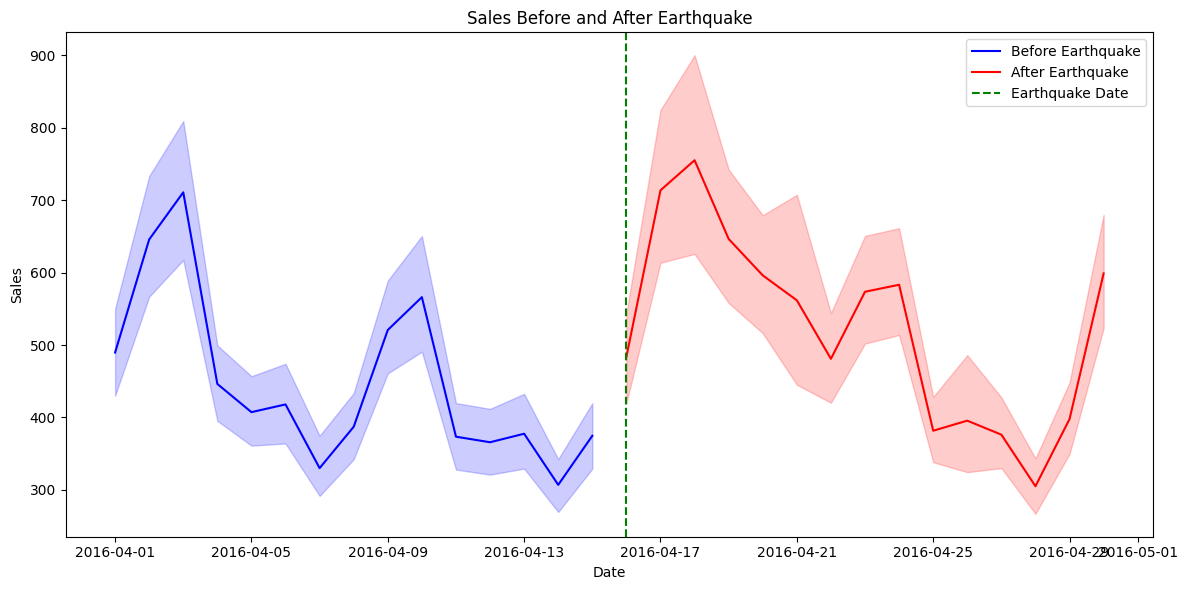

In [53]:
# Focusing on just April sales 
april_sales = final_train_df[(final_train_df.index >= '2016-04-01') & (final_train_df.index <= '2016-04-30')]

# Filter data for the period before and after the earthquake
earthquake_date = "2016-04-16"
post_earthquake = april_sales[april_sales.index >= earthquake_date]
pre_earthquake = april_sales[april_sales.index < earthquake_date]

plt.figure(figsize=(12,6))
# Spliting the data into pre and post-earthquake periods
sns.lineplot(data=pre_earthquake, x= pre_earthquake.index, y='sales', label='Before Earthquake', color='blue')
sns.lineplot(data=post_earthquake, x=post_earthquake.index, y='sales', label='After Earthquake', color='red')

# Create a line plot to visualize sales before and after the earthquake
plt.axvline(pd.to_datetime(earthquake_date), color='green', linestyle='--', label='Earthquake Date')

plt.title("Sales Before and After Earthquake")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


From the visualisation above, 
- we can see that just a few days after the earth quake date, the sales begun to peak which might be due to the urgent need of products such as water,food, clothing to provide help to the victims of the fire outbreak.
The sales decline and later followed the normal days sales trend.

#### Question 5
 Are certain stores or groups of stores selling more products? (Cluster, city, state, type)


#### Merging the training data with the stores data

In [54]:
# View the first five rows of the stores data
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [55]:
# view the last five rows of the stores data
stores_df.tail()

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [56]:
# check for null values 
stores_df.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [57]:
# check for duplicates
stores_df.duplicated().sum()

0

In [58]:
# Merge the stores dataframe and the final_train_df
store_train_df = pd.merge(final_train_df,stores_df,on="store_nbr",how="inner")
store_train_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter,city,state,type,cluster
0,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
1,1,BABY CARE,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
2,1,BEAUTY,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
3,1,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
4,1,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,1,1,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,9,POULTRY,0.00,0.00,December,12,2016,6,Sunday,25,4,Quito,Pichincha,B,6
3008012,9,PREPARED FOODS,0.00,0.00,December,12,2016,6,Sunday,25,4,Quito,Pichincha,B,6
3008013,9,PRODUCE,0.00,0.00,December,12,2016,6,Sunday,25,4,Quito,Pichincha,B,6
3008014,9,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,December,12,2016,6,Sunday,25,4,Quito,Pichincha,B,6


In [59]:
# check for nulls
store_train_df.isna().sum()

store_nbr       0
family          0
sales           0
onpromotion     0
month_name      0
month           0
year            0
day             0
day_name        0
day_of_month    0
quarter         0
city            0
state           0
type            0
cluster         0
dtype: int64

In [60]:
# check for duplicates
store_train_df.duplicated().sum()

0

#### Answering of the analytical question

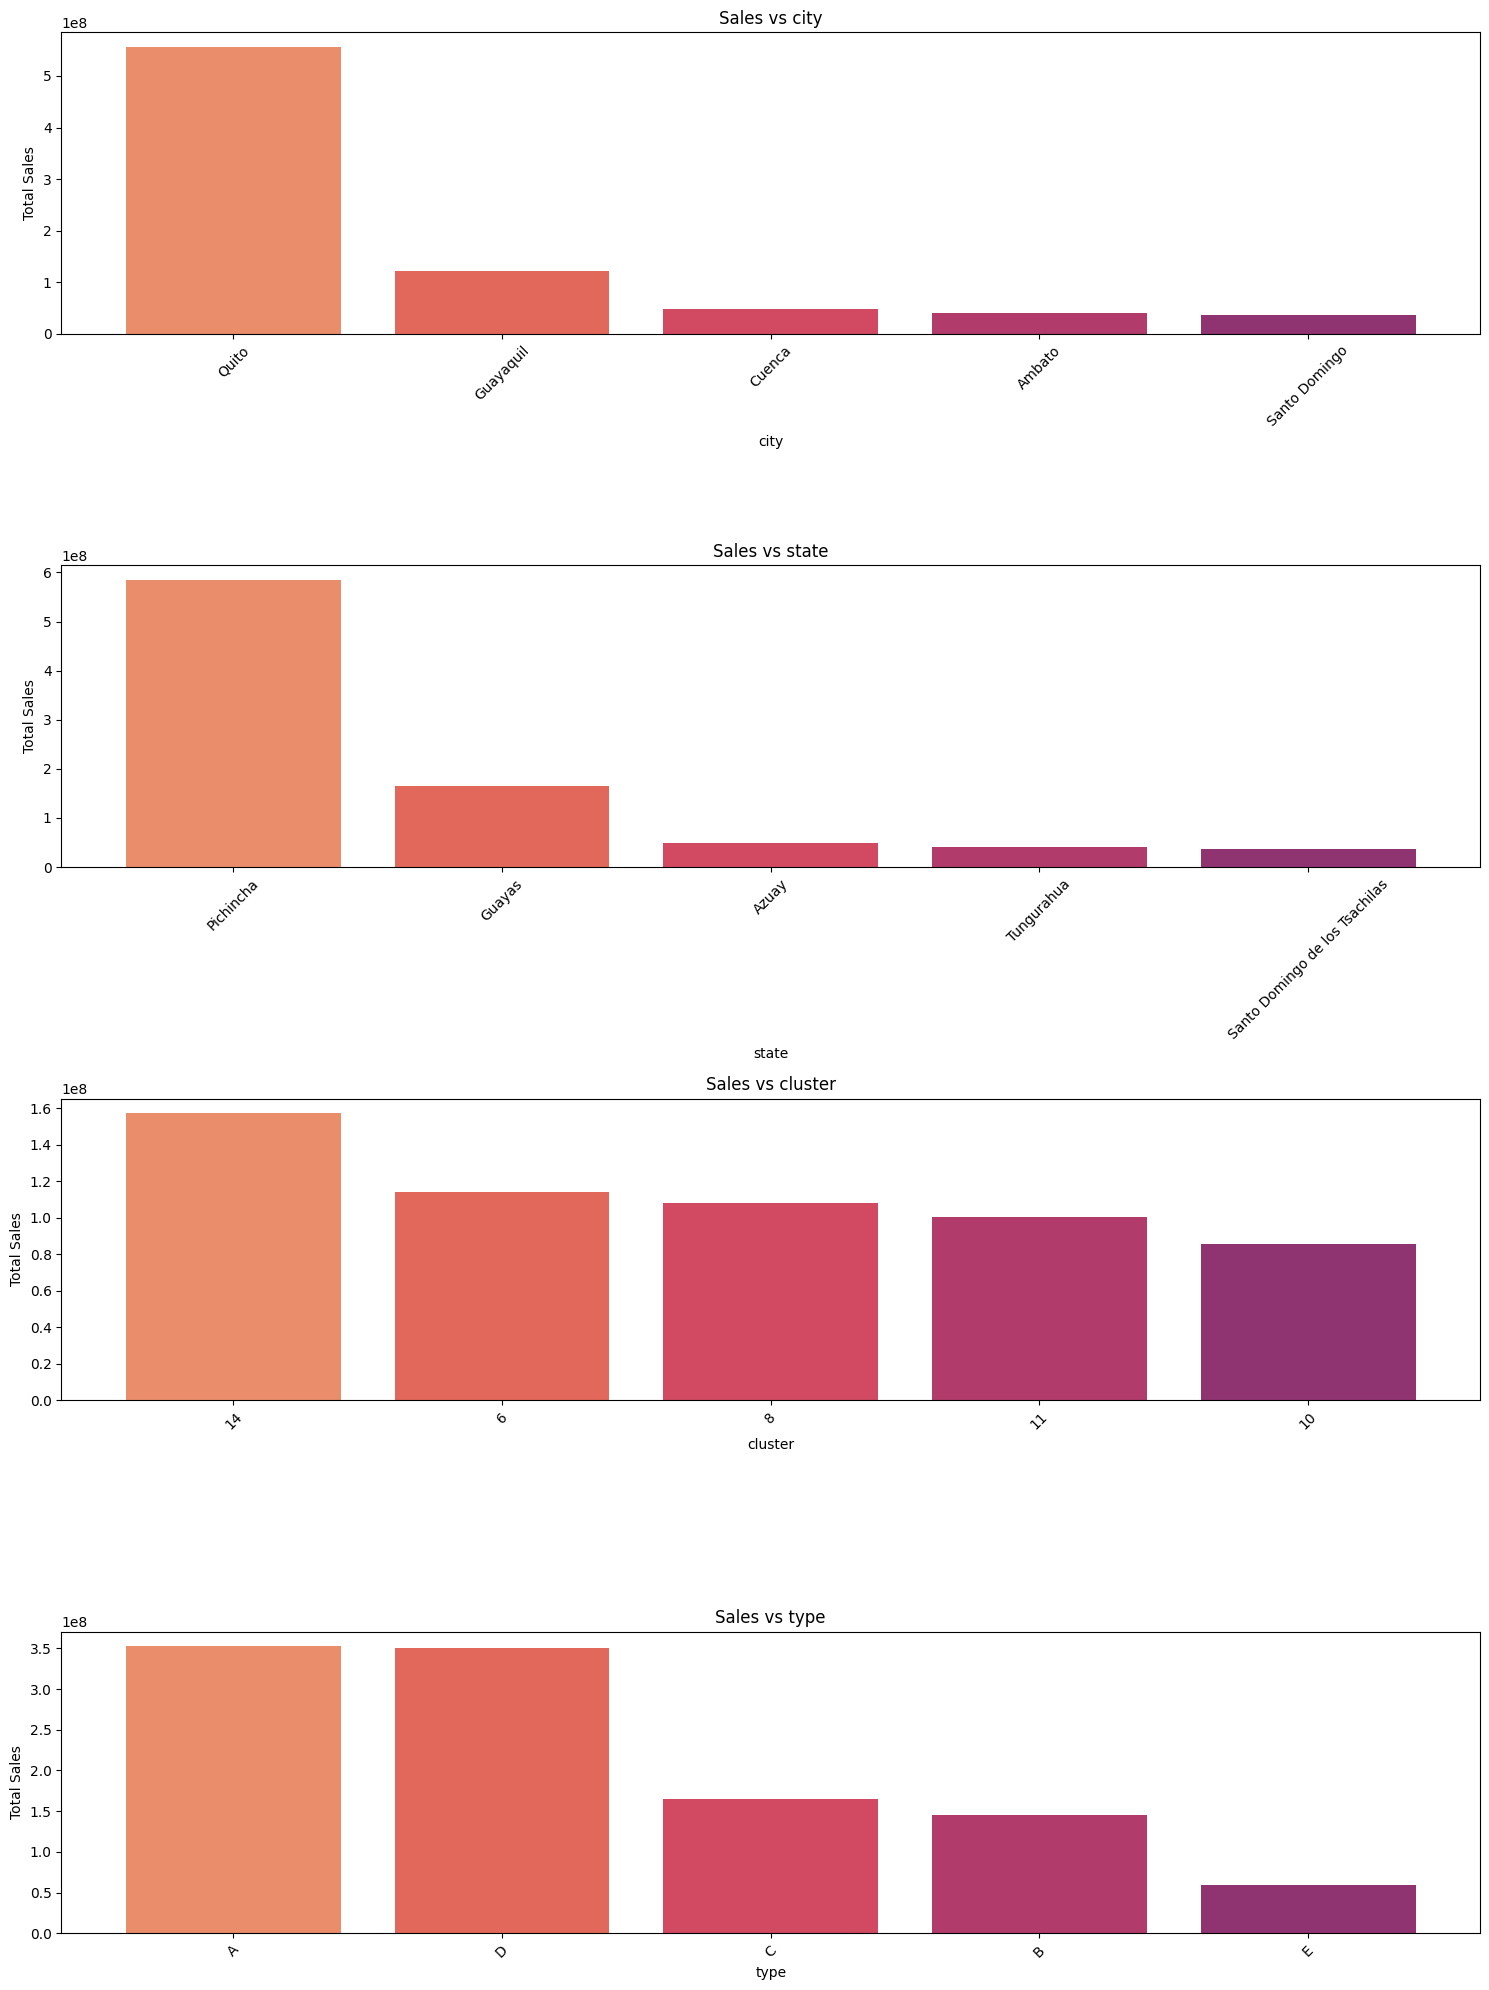

In [61]:
group_by_columns = ["city","state","cluster","type"]
# Define your custom color palette
custom_palette = sns.color_palette("flare")
# Plotting
fig, axs = plt.subplots(nrows = len(group_by_columns),ncols=1,figsize=(15,5*len(group_by_columns)))

# loop through the group_by_columns
for id, column in enumerate(group_by_columns):
    grouped_sales = store_train_df.groupby(column)["sales"].sum().sort_values(ascending=False).head(5)
    grouped_sales.index = grouped_sales.index.astype(str)

    # Plotting the individual visualizations on its own subplot
    axs[id].bar(grouped_sales.index,grouped_sales,color=custom_palette,width=0.8)
    axs[id].set_xlabel(column)
    axs[id].set_ylabel("Total Sales")
    axs[id].set_title(f"Sales vs {column}")
    axs[id].tick_params(axis = "x", rotation = 45)

plt.tight_layout()
plt.show()

#### Question 6
Are sales affected by promotions, oil prices and holidays?

##### Effects of product promotions on Sales

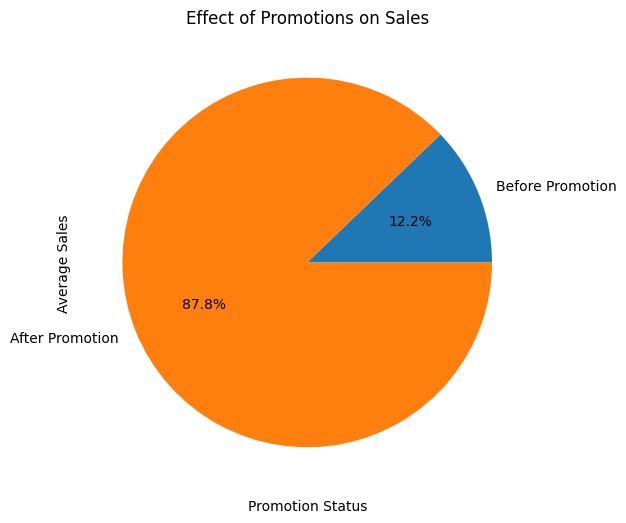

In [62]:
# Check the effect of promotions on sales  
before_promo_df = final_train_df[final_train_df["onpromotion"] == 0]
after_promo_df = final_train_df[final_train_df["onpromotion"] >= 1]

# Group product sales by onpromotion
sales_before_promo = before_promo_df["sales"].mean()
sales_after_promo= after_promo_df["sales"].mean()
labels = ["Before Promotion","After Promotion"]
sales = [sales_before_promo,sales_after_promo]

# Plotting
plt.figure(figsize=(8,6))
plt.pie(sales,labels=labels,autopct="%1.1f%%")
plt.xlabel('Promotion Status')
plt.ylabel('Average Sales')
plt.title('Effect of Promotions on Sales')
plt.show()

#### Effect of Oil Prices On Sales 

In [63]:
# Check the first five rows of the oil data
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [64]:
# check the last five rows of the oil data
oil_df.tail()

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [65]:
# check for null values
oil_df.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [66]:
# Fill the missing values 
oil_df["dcoilwtico"] = oil_df["dcoilwtico"].interpolate(method="linear")
oil_df.isna().sum()

date          0
dcoilwtico    1
dtype: int64

In [67]:
oil_df["dcoilwtico"].fillna(method="bfill",inplace=True)

In [68]:
# check for nulls still present
oil_df.isna().sum()

date          0
dcoilwtico    0
dtype: int64

In [69]:
# check the info about the dataset
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [70]:
# convert date column from object to datetime
oil_df["date"] = pd.to_datetime(oil_df["date"])
# set the date column as index
oil_df.set_index("date",inplace=True)
oil_train_df = pd.merge(final_train_df,oil_df,how="inner",left_index=True,right_index=True)
oil_train_df



,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter,dcoilwtico
date,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,1,1,93.14
2013-01-01,1,BABY CARE,0.00,0.00,January,1,2013,1,Tuesday,1,1,93.14
2013-01-01,1,BEAUTY,0.00,0.00,January,1,2013,1,Tuesday,1,1,93.14
2013-01-01,1,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,1,1,93.14
2013-01-01,1,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,1,1,93.14
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,9,POULTRY,0.00,0.00,December,12,2015,4,Friday,25,4,36.99
2015-12-25,9,PREPARED FOODS,0.00,0.00,December,12,2015,4,Friday,25,4,36.99
2015-12-25,9,PRODUCE,0.00,0.00,December,12,2015,4,Friday,25,4,36.99


In [71]:
# check for nulls
oil_train_df.isna().sum()

store_nbr       0
family          0
sales           0
onpromotion     0
month_name      0
month           0
year            0
day             0
day_name        0
day_of_month    0
quarter         0
dcoilwtico      0
dtype: int64

#### Line Plot of Oil prices and Sales.

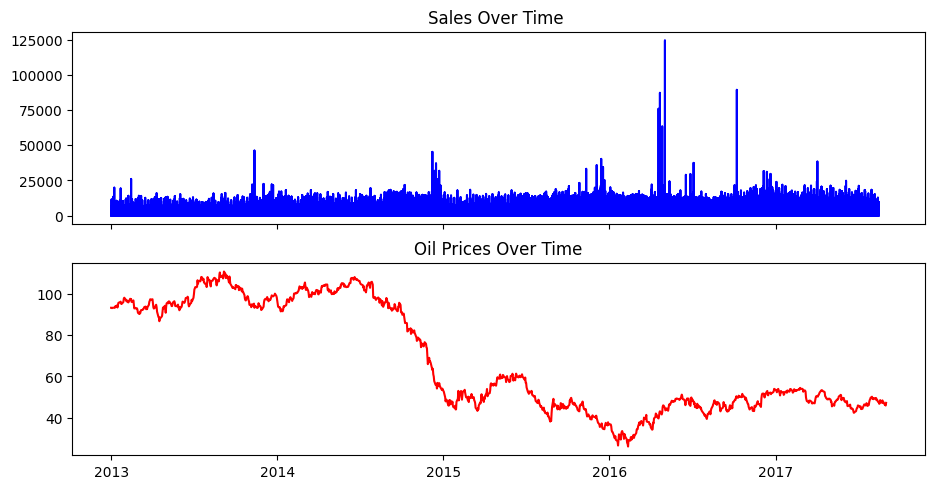

In [72]:
# line plot of sales 
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(11,5.5), sharex=True)
ax1.plot(final_train_df["sales"],color="Blue")
# line plot of oil prices 
ax2.plot(oil_df["dcoilwtico"],color="Red")
ax1.set_title("Sales Over Time ")
ax2.set_title("Oil Prices Over Time")
plt.show()

From the graph, we can see that there is a significant relationship between sales generated by stores and the oil price. People tend to purchase more from the store when oil prices reduces.

#### Effect of Holidays on Sales 
**NOTE:** Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

In [73]:
# view the first five rows of the holiday data
holiday_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [74]:
# check the last five rows
holiday_df.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [75]:
# check for null values in 
holiday_df.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [76]:
# check the info about the data
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [77]:
holiday_df["type"].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

#### Replace the Holiday type that were transferred to Work Day this was to cater for the transferred date

In [78]:
# Get the Holidays that was transferred
transferred_holidays = holiday_df.loc[(holiday_df["type"]=="Holiday") & (holiday_df["transferred"] ==True) ]
transferred_holidays

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [79]:
#Replace type to work day
transferred_holidays["type"] = transferred_holidays["type"].replace({"Holiday":"Work Day"})
transferred_holidays

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Work Day,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Work Day,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Work Day,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Work Day,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Work Day,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Work Day,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Work Day,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Work Day,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Work Day,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Work Day,National,Ecuador,Primer Grito de Independencia,True


In [80]:
# Merge the transferred_data back to the holiday data
holiday_df.update(transferred_holidays)
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [81]:
# check for unique type values after the update
holiday_df["type"].value_counts()

type
Holiday       209
Event          56
Additional     51
Work Day       17
Transfer       12
Bridge          5
Name: count, dtype: int64

In [82]:
# convert date to datetime and set it as index 

holiday_df["date"] = pd.to_datetime(holiday_df["date"])
holiday_df.set_index("date",inplace=True)
holiday_train_df = pd.merge(final_train_df,holiday_df,how="inner",left_index=True,right_index=True)
holiday_train_df
 

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,day_of_month,quarter,type,locale,locale_name,description,transferred
date,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,1,1,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BABY CARE,0.00,0.00,January,1,2013,1,Tuesday,1,1,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEAUTY,0.00,0.00,January,1,2013,1,Tuesday,1,1,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,1,1,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,1,1,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-25,9,POULTRY,0.00,0.00,December,12,2016,6,Sunday,25,4,Holiday,National,Ecuador,Navidad,False
2016-12-25,9,PREPARED FOODS,0.00,0.00,December,12,2016,6,Sunday,25,4,Holiday,National,Ecuador,Navidad,False
2016-12-25,9,PRODUCE,0.00,0.00,December,12,2016,6,Sunday,25,4,Holiday,National,Ecuador,Navidad,False


#### Answering the analytical question

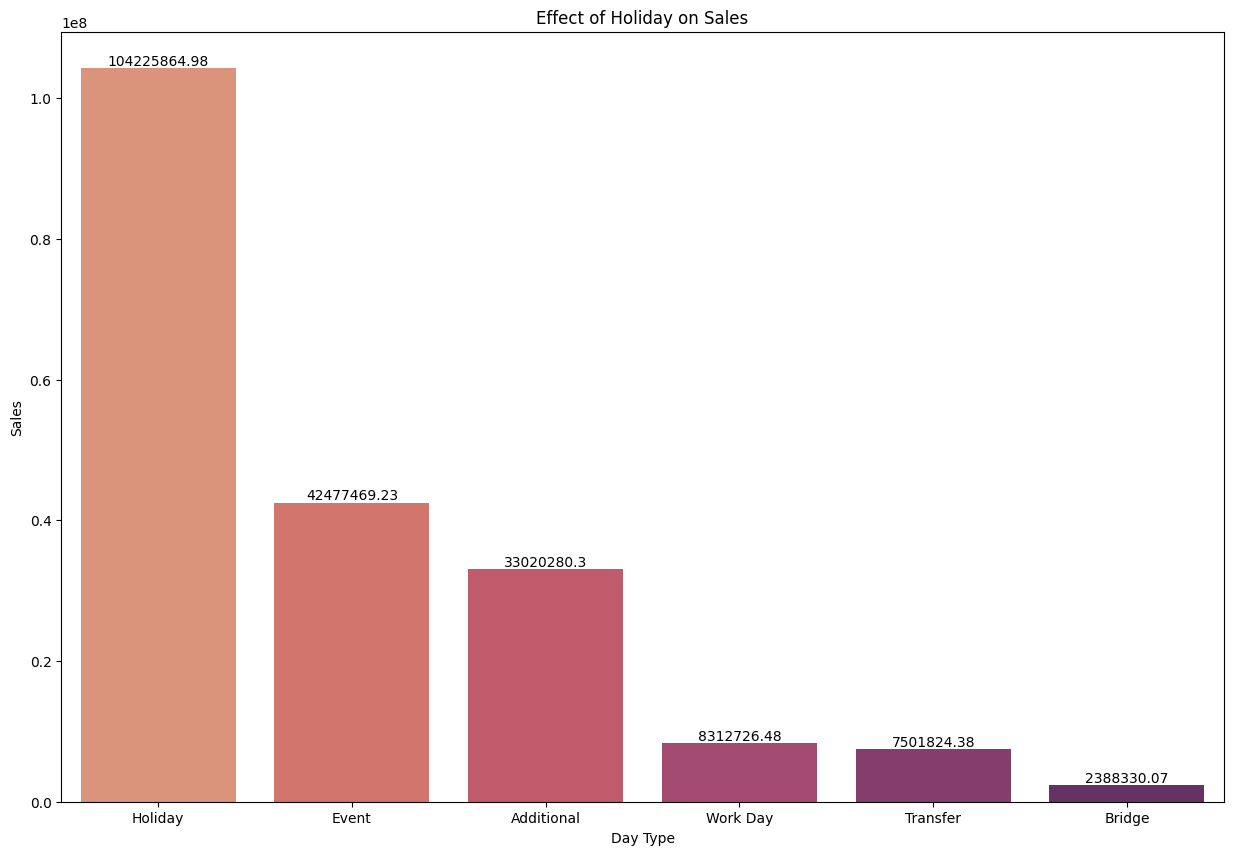

In [ ]:
# Group the sum of sales by Holiday Type
sales_effect_by_holiday = holiday_train_df.groupby("type")["sales"].sum().sort_values(ascending=False).round(2)
# convert sales_effect_by_holiday to DataFrame
sales_effect_by_holiday_df = pd.DataFrame(sales_effect_by_holiday)
# plot the result on barplot
sns.barplot(data=sales_effect_by_holiday_df,x=sales_effect_by_holiday.index, y="sales",palette="flare")
plt.title("Effect of Holiday on Sales")
plt.xlabel("Day Type")
plt.ylabel("Sales")

# Annotate bars with sales values
for index, value in enumerate(sales_effect_by_holiday_df["sales"]):
    plt.text(index, value, str(value), ha="center", va="bottom")
plt.show()

From the visualization above, we can see that sales increase significantly on holidays which implies that more workers and products should be available on holidays.

#### Question 7
What analysis can we get from the date and its extractable features?

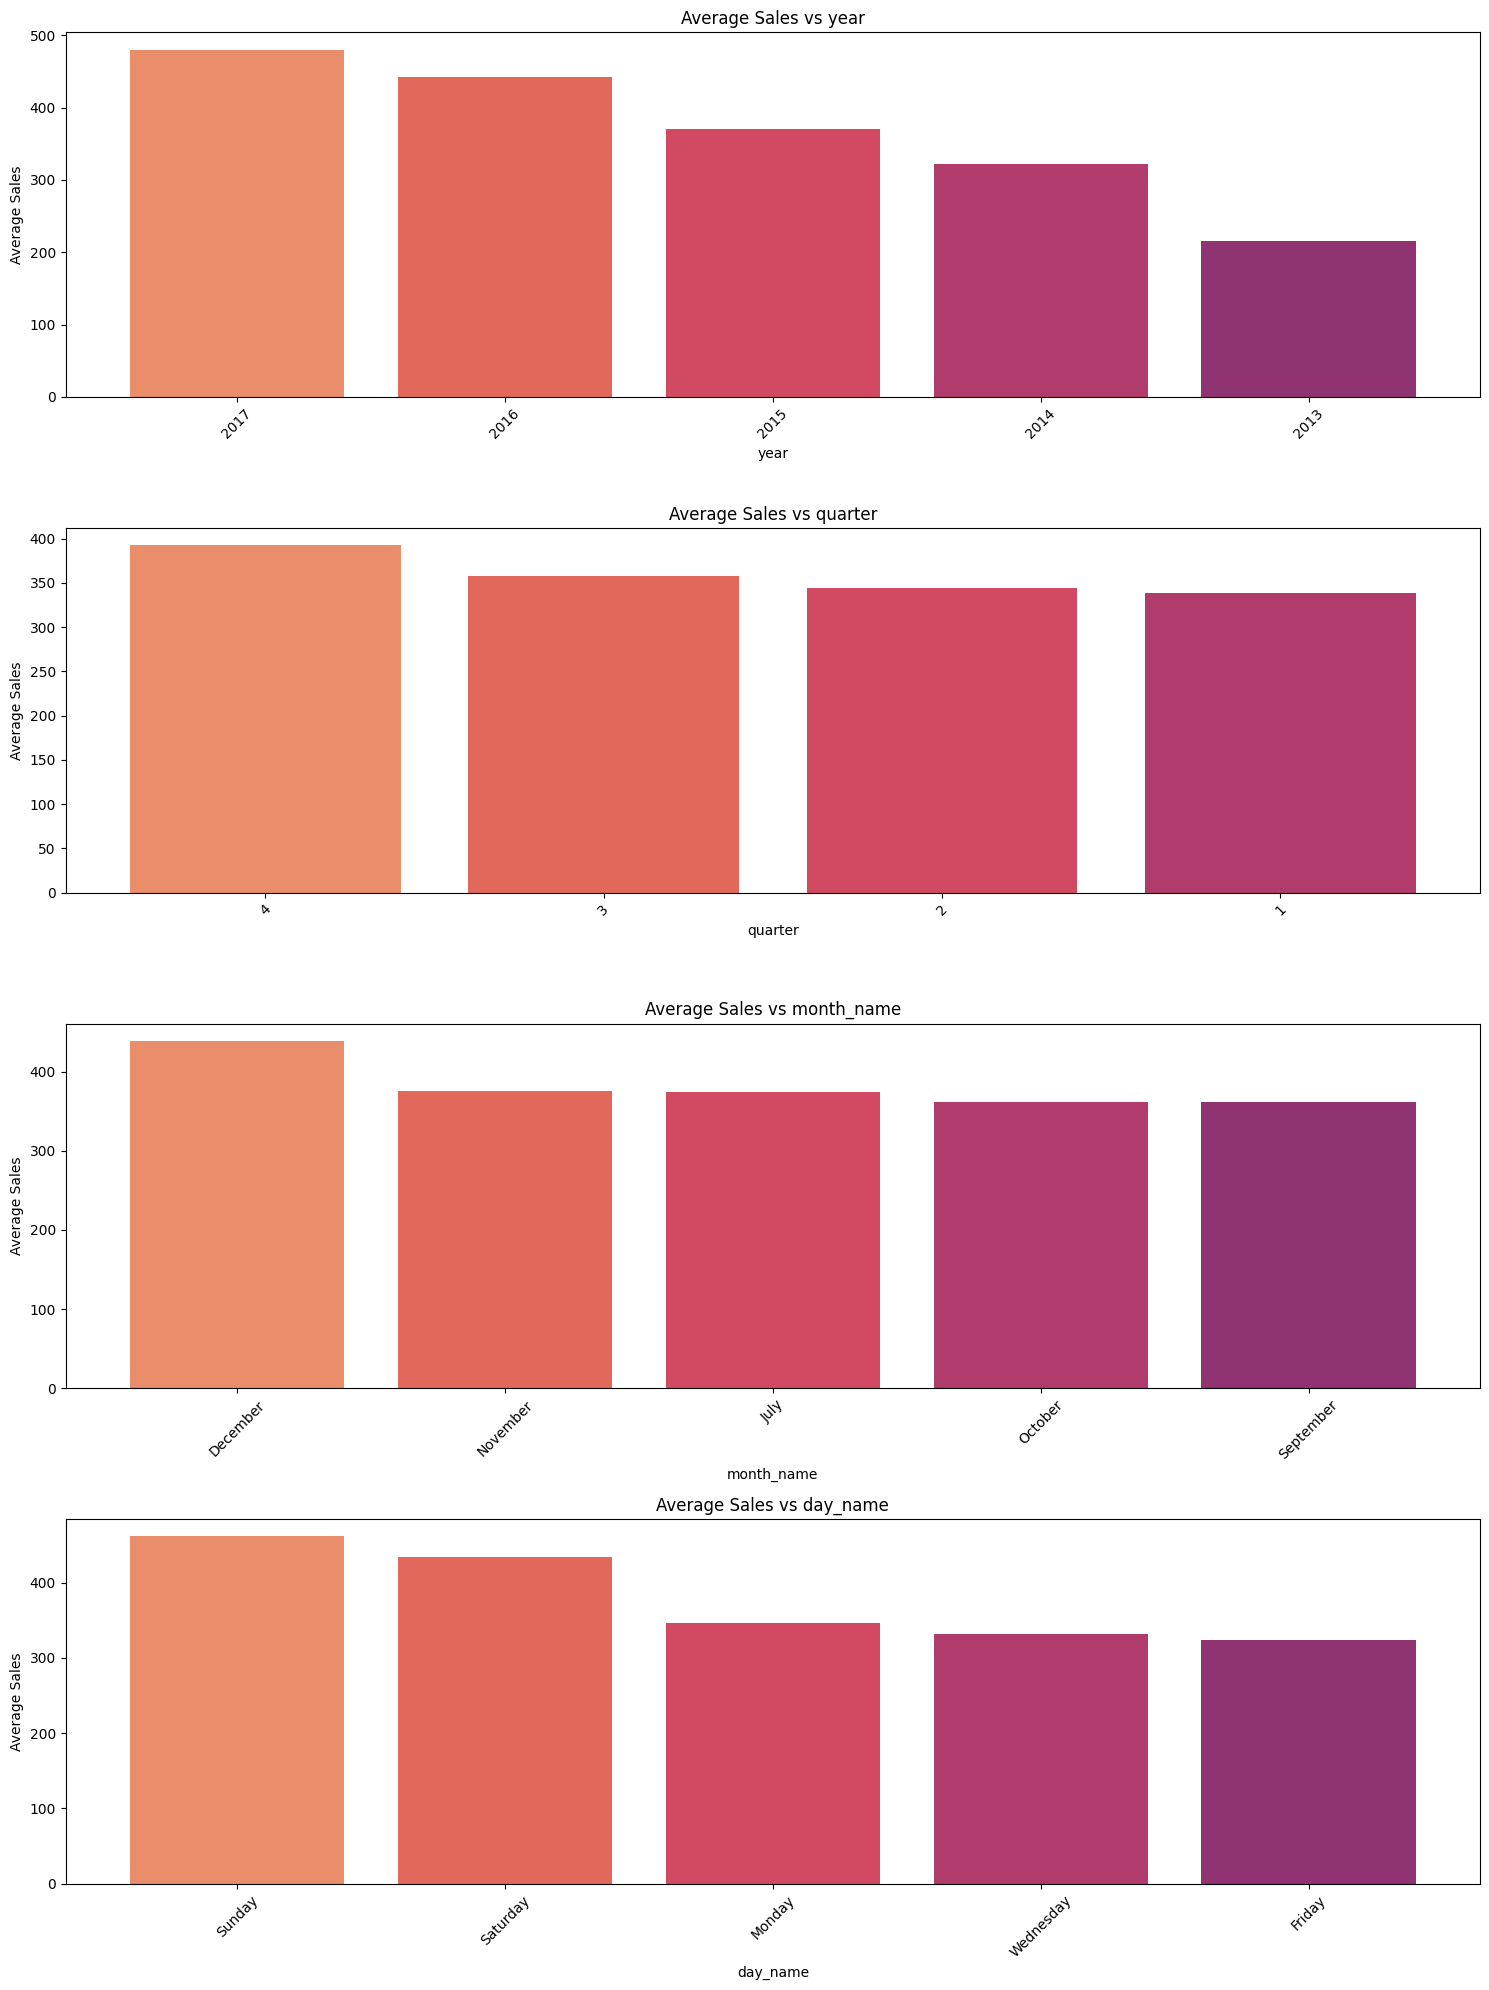

In [ ]:
# Plot Heatmap To Visualize The Correlation of Features
group_by_columns = ["year","quarter","month_name","day_name"]
# Define your custom color palette
custom_palette = sns.color_palette("flare")
# Plotting
fig, axs = plt.subplots(nrows = len(group_by_columns),ncols=1,figsize=(15,5*len(group_by_columns)))

# loop through the group_by_columns
for id, column in enumerate(group_by_columns):
    grouped_sales = final_train_df.groupby(column)["sales"].mean().sort_values(ascending=False).head(5)
    grouped_sales.index = grouped_sales.index.astype(str)

    # Plotting the individual visualizations on its own subplot
    axs[id].bar(grouped_sales.index,grouped_sales,color=custom_palette,width=0.8)
    axs[id].set_xlabel(column)
    axs[id].set_ylabel("Average Sales")
    axs[id].set_title(f"Average Sales vs {column}")
    axs[id].tick_params(axis = "x", rotation = 45)

plt.tight_layout()
plt.show()

#### Question 8
Which product family and stores did the promotions affect?

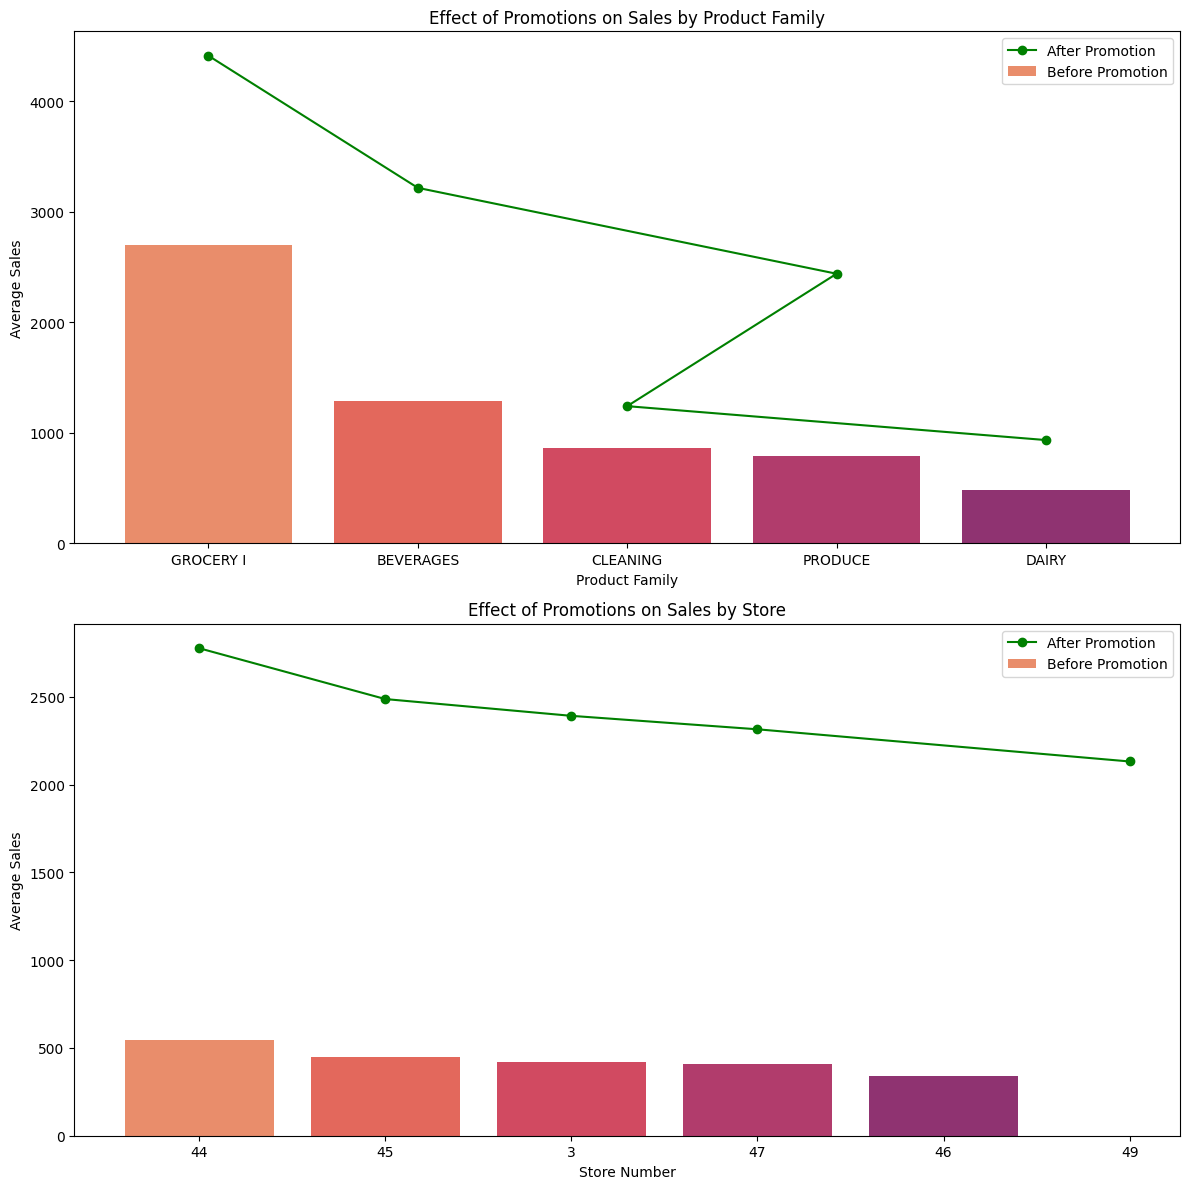

In [ ]:
# convert store_nbr to string

store_train_df["store_nbr"] = store_train_df["store_nbr"].astype(str)
# Check the effect of promotions on sales  
before_promo_df = store_train_df[store_train_df["onpromotion"] == 0]
after_promo_df = store_train_df[store_train_df["onpromotion"] >= 1]

# Group sales made for each product family before and after promotions
family_sales_before_promo = before_promo_df.groupby("family")["sales"].mean().sort_values(ascending=False).head(5)
family_sales_after_promo = after_promo_df.groupby("family")["sales"].mean().sort_values(ascending=False).head(5)

# Group sales made for each product family before and after promotions
store_sales_before_promo= before_promo_df.groupby("store_nbr")["sales"].mean().sort_values(ascending=False).head(5)
store_sales_after_promo = after_promo_df.groupby("store_nbr")["sales"].mean().sort_values(ascending=False).head(5)



# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plotting for product families
axs[0].bar(family_sales_before_promo.index, family_sales_before_promo.values, color=custom_palette, label='Before Promotion')
axs[0].plot(family_sales_after_promo.index, family_sales_after_promo.values, marker='o', color='green', label='After Promotion')
axs[0].set_title('Effect of Promotions on Sales by Product Family')
axs[0].set_xlabel('Product Family')
axs[0].set_ylabel('Average Sales')
axs[0].legend()

# Plotting for stores
axs[1].bar(store_sales_before_promo.index, store_sales_before_promo.values, color=custom_palette, label='Before Promotion')
axs[1].plot(store_sales_after_promo.index, store_sales_after_promo.values, marker='o', color='green', label='After Promotion')
axs[1].set_title('Effect of Promotions on Sales by Store')
axs[1].set_xlabel('Store Number')
axs[1].set_ylabel('Average Sales')
axs[1].legend()

plt.tight_layout()
plt.show()

From the graph, we can see that product promotions have a siginificant impact on sales for individual stores and product families

#### Question 9

#### Question 10
Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [ ]:
# Convert the index to a PeriodIndex with monthly frequency
final_train_df.index = pd.PeriodIndex(final_train_df.index, freq='M')

# Extract the last day of each month
last_day_of_month = final_train_df.index.to_timestamp(how='end')

# Filter sales data for the 15th and last days of the month
payment_dates_sales = final_train_df[(final_train_df['day_of_month'] == 15) | (final_train_df["day_of_month"] == last_day_of_month.day)]

# Calculate average sales on payment dates
avg_sales_on_payment_dates = payment_dates_sales['sales'].mean().round(2)

# Calculate average sales on other days
other_days_sales = final_train_df[~((final_train_df['day_of_month'] == 15) | (final_train_df["day_of_month"] == last_day_of_month.day))]

# Calculate average sales on other days
avg_sales_other_days = other_days_sales['sales'].mean().round(2)

# Print the average sales on payment dates and other days
print("Average sales on payment dates:", avg_sales_on_payment_dates)
print("Average sales on other days:", avg_sales_other_days)



Average sales on payment dates: 362.49
Average sales on other days: 356.54


#### Hypothesis Testing

**Null Hypothesis (H0):**
There is no significant relationship between sales levels and products promotion at Corporation Favorita.


**Alternative Hypothesis (Ha):**
There is a statistically significant relationship between sales levels and products promotion at Corporation Favorita.

In [ ]:


# Extract the relevant variables for the hypothesis test
promo_sales = final_train_df[final_train_df['onpromotion'] >= 1]['sales']
non_promo_sales = final_train_df[final_train_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): There is no significant relationship between sales levels and products promotions at Corporation Favorita.")
print("Alternative Hypothesis (H1): There is a statistically significant relationship between sales levels and products promotions at Corporation Favorita.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis: There is no significant relationship between sales levels and products promotions at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between sales levels and products promotions at Corporation Favorita.")


Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): There is no significant relationship between sales levels and products promotions at Corporation Favorita.
Alternative Hypothesis (H1): There is a statistically significant relationship between sales levels and products promotions at Corporation Favorita.
--------------------------------------------------
Test Statistic: 665.4144504427975
P-value: 0.0
Reject the null hypothesis: There is no significant relationship between sales levels and products promotions at Corporation Favorita.


## Data Preparation

### Make Data Stationary
- Dtrending : Differencing & Seasonal differencing : y(t) = y(t) - y(t-1)
- Rolling Statistics: Moving Average
- Transformation : log,sqrt, cbrt and differencing

#### Modeling

In [ ]:
####

#### Model Evaluation

#### Persist the Model